# KPI Anomaly Detection

Group: 
- Zihang WANG
- Liyang FANG

Dataset:
* [KPI Anomaly Detectionn](https://competition.aiops-challenge.com/home/competition/1484452272200032281)

## EDA

### Data Preparation

In [2]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

warnings.filterwarnings("ignore")

In [4]:
data_folder = "../data/"

train_file = "train.csv"
# test_file = "test.csv"

train_path = data_folder + train_file
# test_path = data_folder + test_file

In [5]:
df_train = pd.read_csv(train_path).rename(columns={"KPI ID": "kpi_id"})
df_train["datetime"] = pd.to_datetime(df_train.timestamp, unit="s")

In [5]:
# df_test = pd.read_csv(test_path).rename(columns={"KPI ID": "kpi_id"})
# df_test["datetime"] = pd.to_datetime(df_test.timestamp, unit="s")

In [6]:
df_train.head()

timestamp     value  label            kpi_id            datetime
0  1493568000  1.901639      0  02e99bd4f6cfb33f 2017-04-30 16:00:00
1  1493568060  1.786885      0  02e99bd4f6cfb33f 2017-04-30 16:01:00
2  1493568120  2.000000      0  02e99bd4f6cfb33f 2017-04-30 16:02:00
3  1493568180  1.885246      0  02e99bd4f6cfb33f 2017-04-30 16:03:00
4  1493568240  1.819672      0  02e99bd4f6cfb33f 2017-04-30 16:04:00

In [7]:
df_train.shape

(2476315, 5)

In [8]:
print(f"Missing values is {df_train.isnull().sum().sum()}")
print(f"Duplicated values is {df_train.duplicated().sum()}")
print(f"Number of unique KPI IDs are {df_train.kpi_id.nunique()}")

Missing values is 0
Duplicated values is 0
Number of unique KPI IDs are 26


Text(0.5, 9.444444444444438, 'missing dates count')

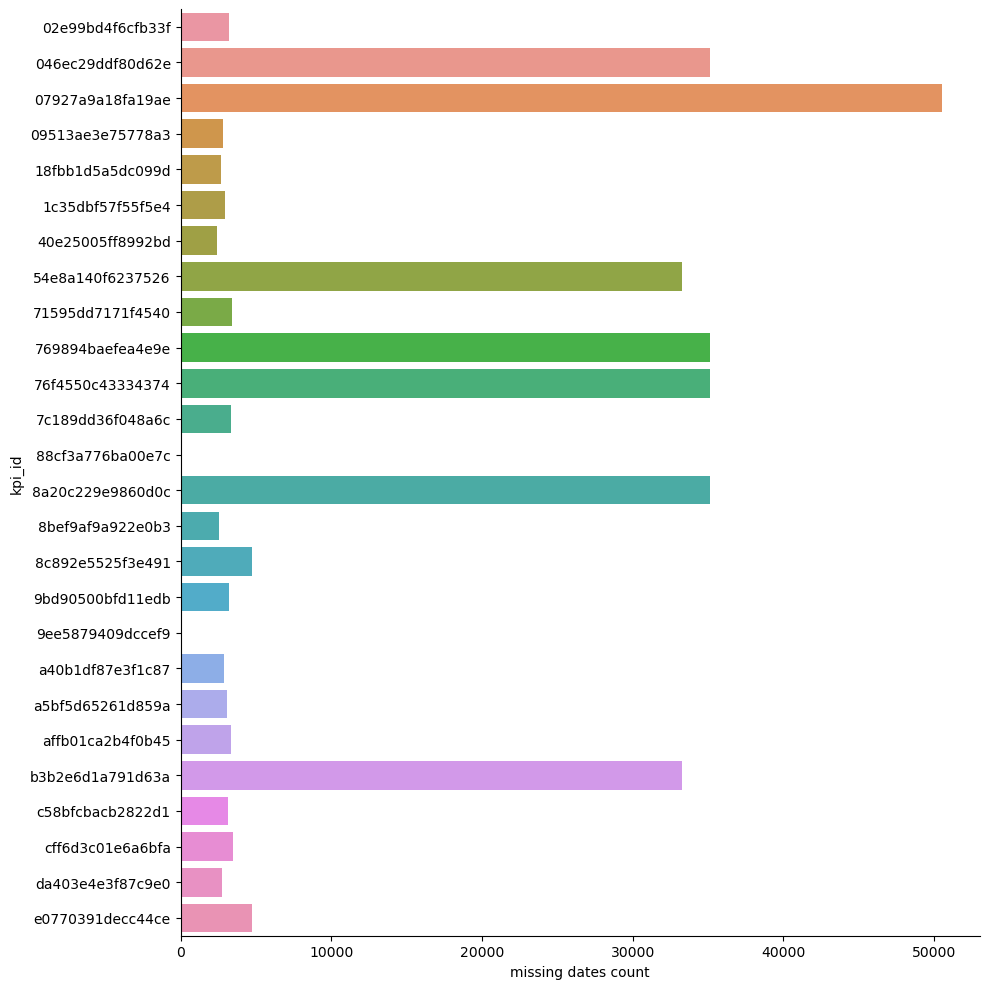

In [7]:
missing_date_per_kip = (
    df_train.groupby("kpi_id")
    .apply(
        lambda x: pd.Series(
            pd.date_range(
                start=x.datetime.min(), end=x.datetime.max(), freq="1min"
            ).difference(x.datetime)
        )
    )
    .reset_index(drop=False)
)
missing_date_per_kip = missing_date_per_kip.rename(columns={0: "datetime"}).drop(
    columns=["level_1"]
)
sns.catplot(
    y="kpi_id", x=None, data=missing_date_per_kip, kind="count", orient="h", height=10
)
plt.xlabel("missing dates count")

In [7]:
def fill_na(data):
    start = data.datetime.min()
    end = data.datetime.max()
    idx = pd.date_range(start=start, end=end, freq="1min")
    data.set_index("datetime", inplace=True)
    data = data.reindex(idx)

    data.timestamp = data.index.astype(int) / 10**9
    data.kpi_id = data.kpi_id.unique()[0]

    data = data.fillna(method="ffill").fillna(method="bfill")
    return data.reset_index(drop=False).rename(columns={"index": "datetime"})


df_train = df_train.groupby("kpi_id").apply(fill_na).reset_index(drop=True)
missing_date_per_kip = (
    df_train.groupby("kpi_id")
    .apply(
        lambda x: pd.Series(
            pd.date_range(start=x.datetime.min(), end=x.datetime.max(), freq="1min")
            .difference(x.datetime)
            .size
        )
    )
    .reset_index(drop=False)
    .rename(columns={0: "missing_dates"})
)

print(f"any missing date? {missing_date_per_kip.missing_dates.any()}")

any missing date? False


### Anomaly exploration 

In [11]:
print(
    f"Percentage of anomalies is {len(df_train[df_train['label'] == 1]) / len(df_train) * 100:.2f}%"
)

Percentage of anomalies is 2.11%


According to the percentage of anomalies we could say that it is only a small proportion of the dataset, which can be seen as an normal situation. 

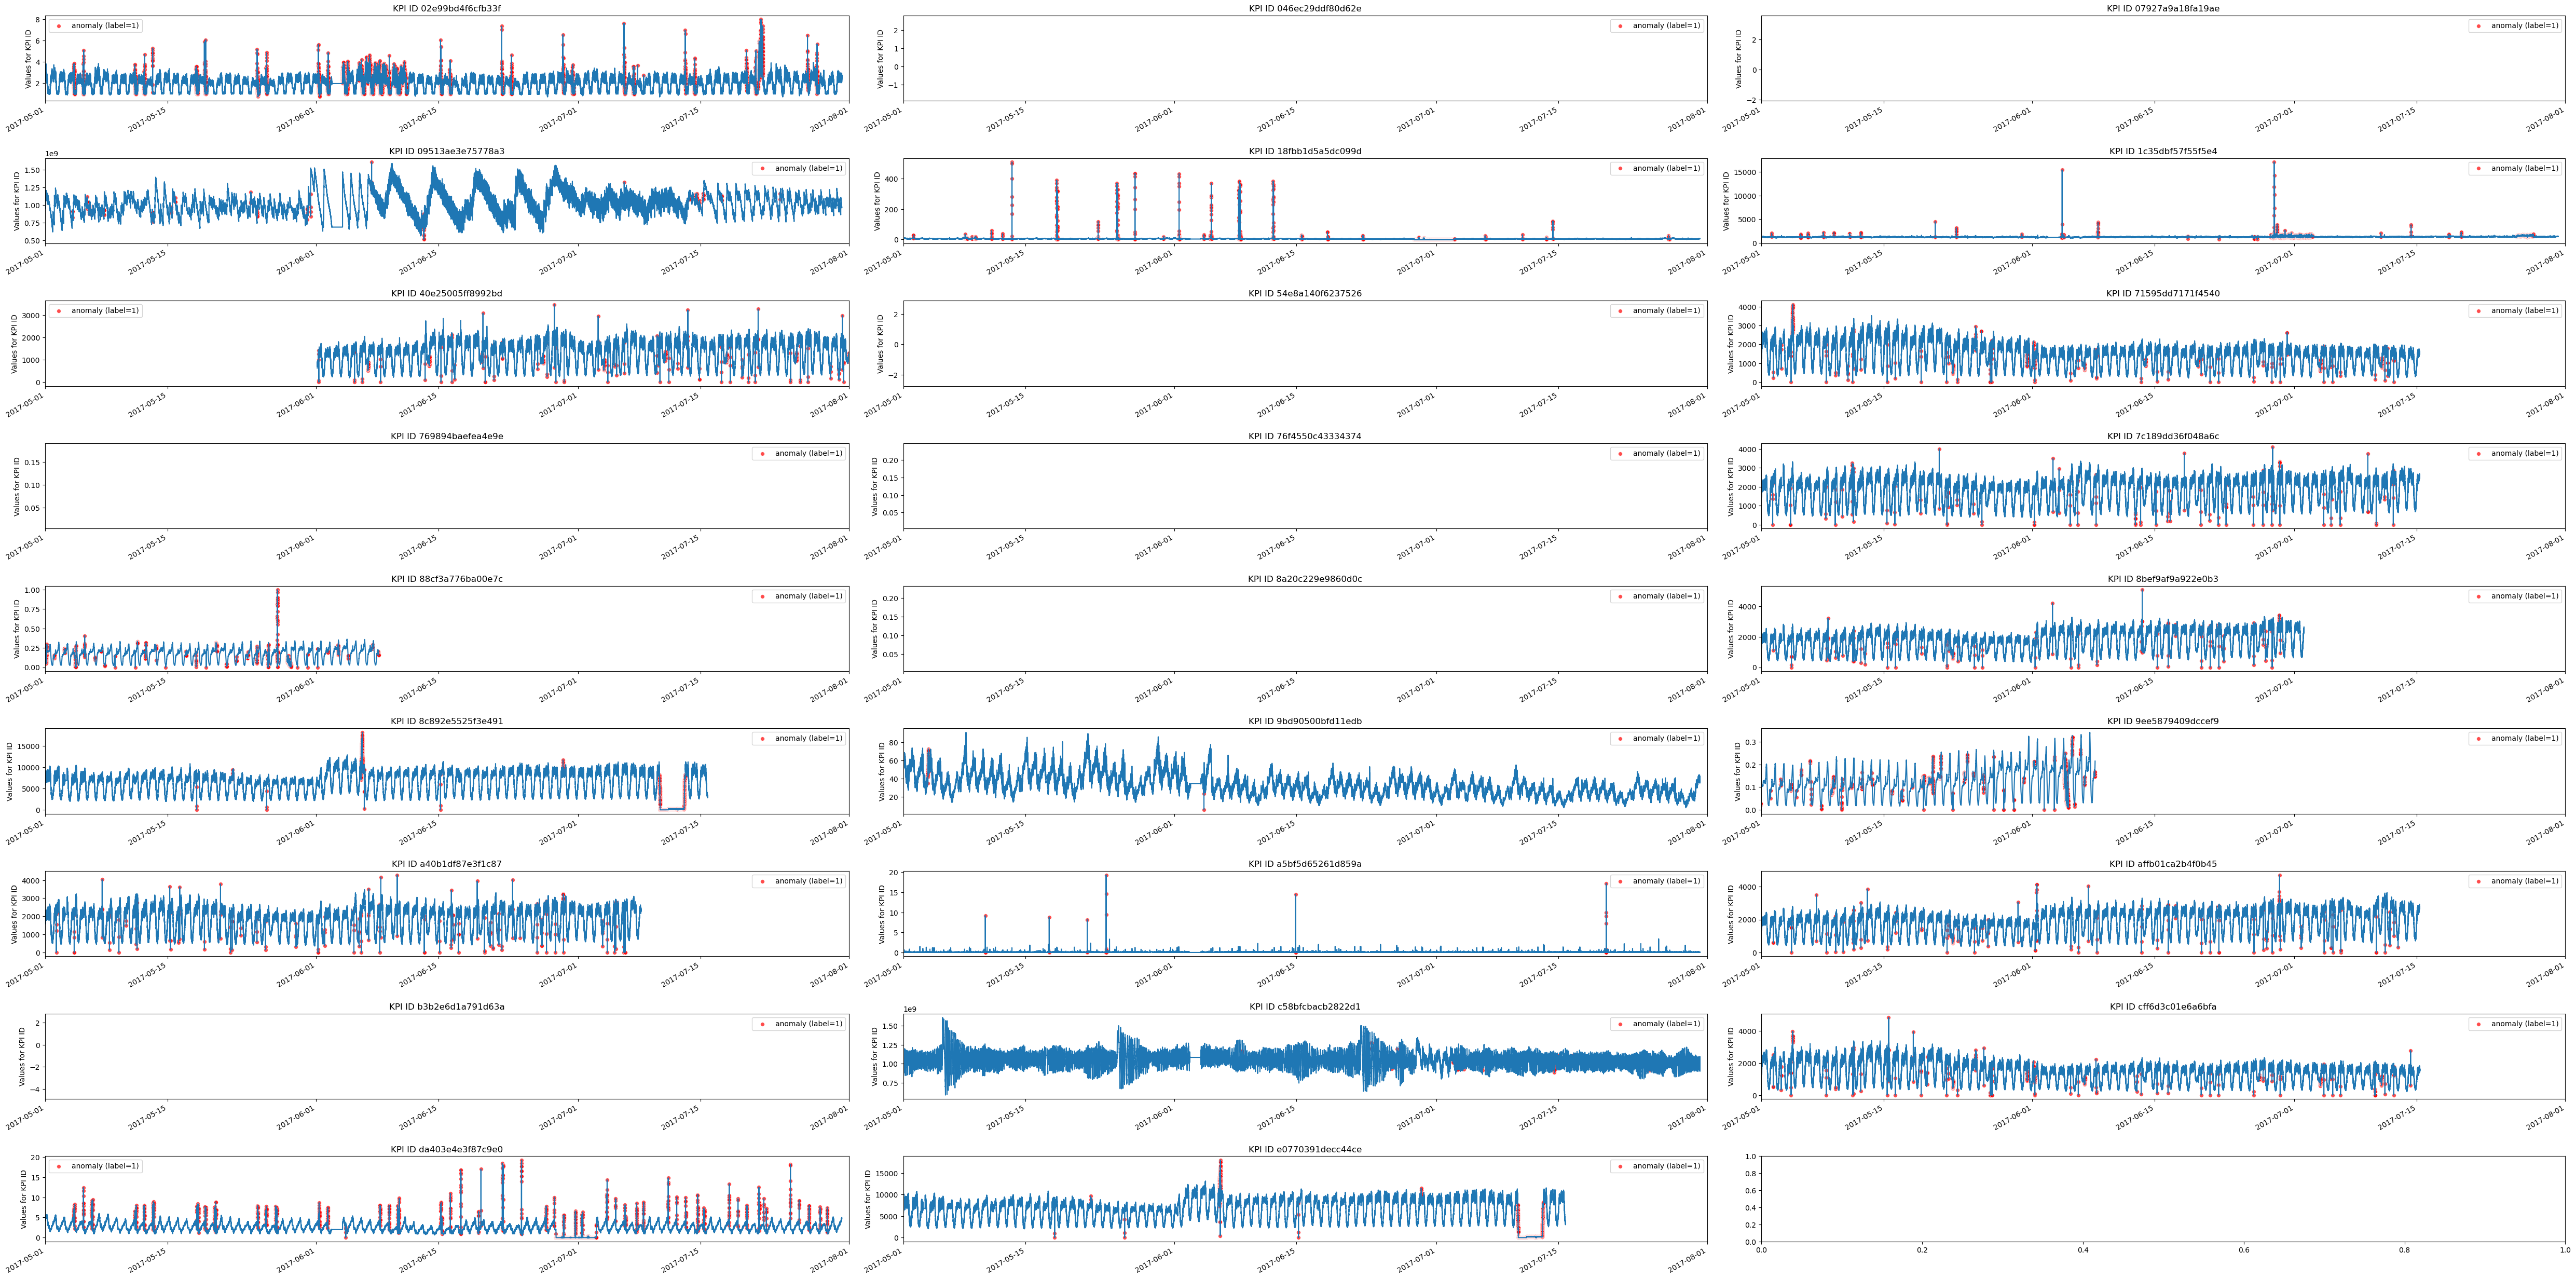

In [12]:
fig, axs = plt.subplots(9, 3, figsize=(50, 25))

for kpi_id, ax in zip(df_train.kpi_id.unique(), axs.flatten()):
    data = df_train[df_train.kpi_id == kpi_id]
    sns.lineplot(data=data, x="datetime", y="value", ax=ax)
    sns.scatterplot(
        data=data[data.label == 1],
        x="datetime",
        y="value",
        color="r",
        s=30,
        alpha=0.7,
        label="anomaly (label=1)",
        ax=ax,
    )
    ax.set_xlim(datetime.datetime(2017, 5, 1), datetime.datetime(2017, 8, 1))
    ax.legend()
    ax.title.set_text(f"KPI ID {kpi_id}")
    ax.set_ylabel("Values for KPI ID")
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
plt.tight_layout(pad=2)
plt.show()

There are at total of 26 KPI ID which contains 7 graphs without abnomalies 

### Data Precessing

From the graph we ploted, There are three typical shapes of plots. We pick one from the three types to as the case study:
 - Period, eg: '7c189dd36f048a6c'
 - Stable, eg: '18fbbld5a5dc099d'
 - Unstable, eg: '09513ae3e75778a3'
We choose the selected KPI to do the further detection in the following sections

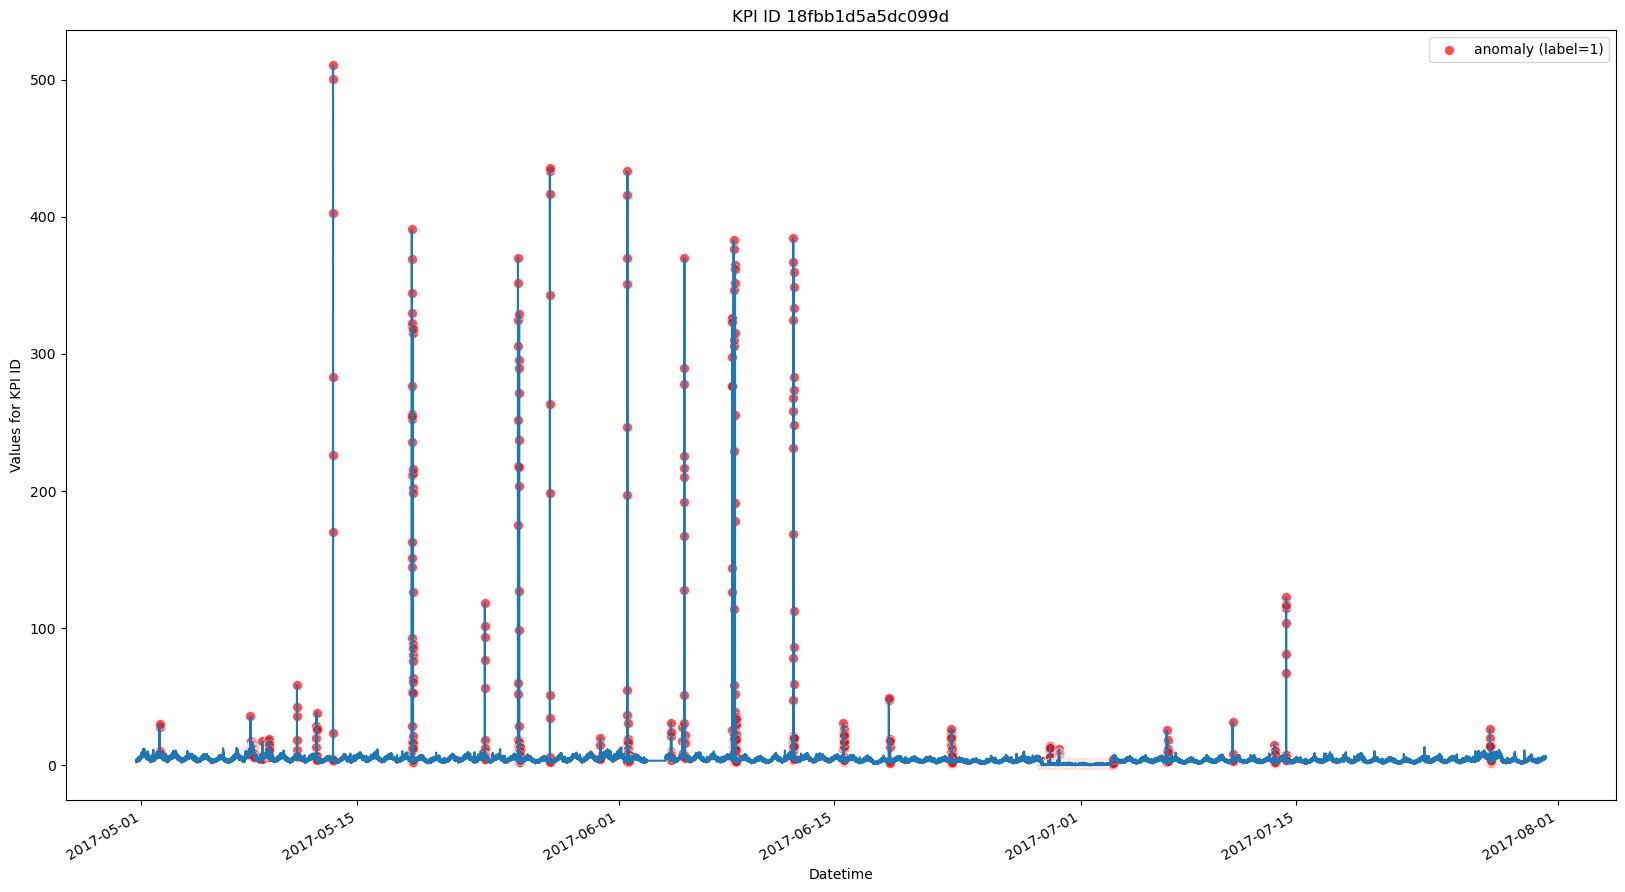

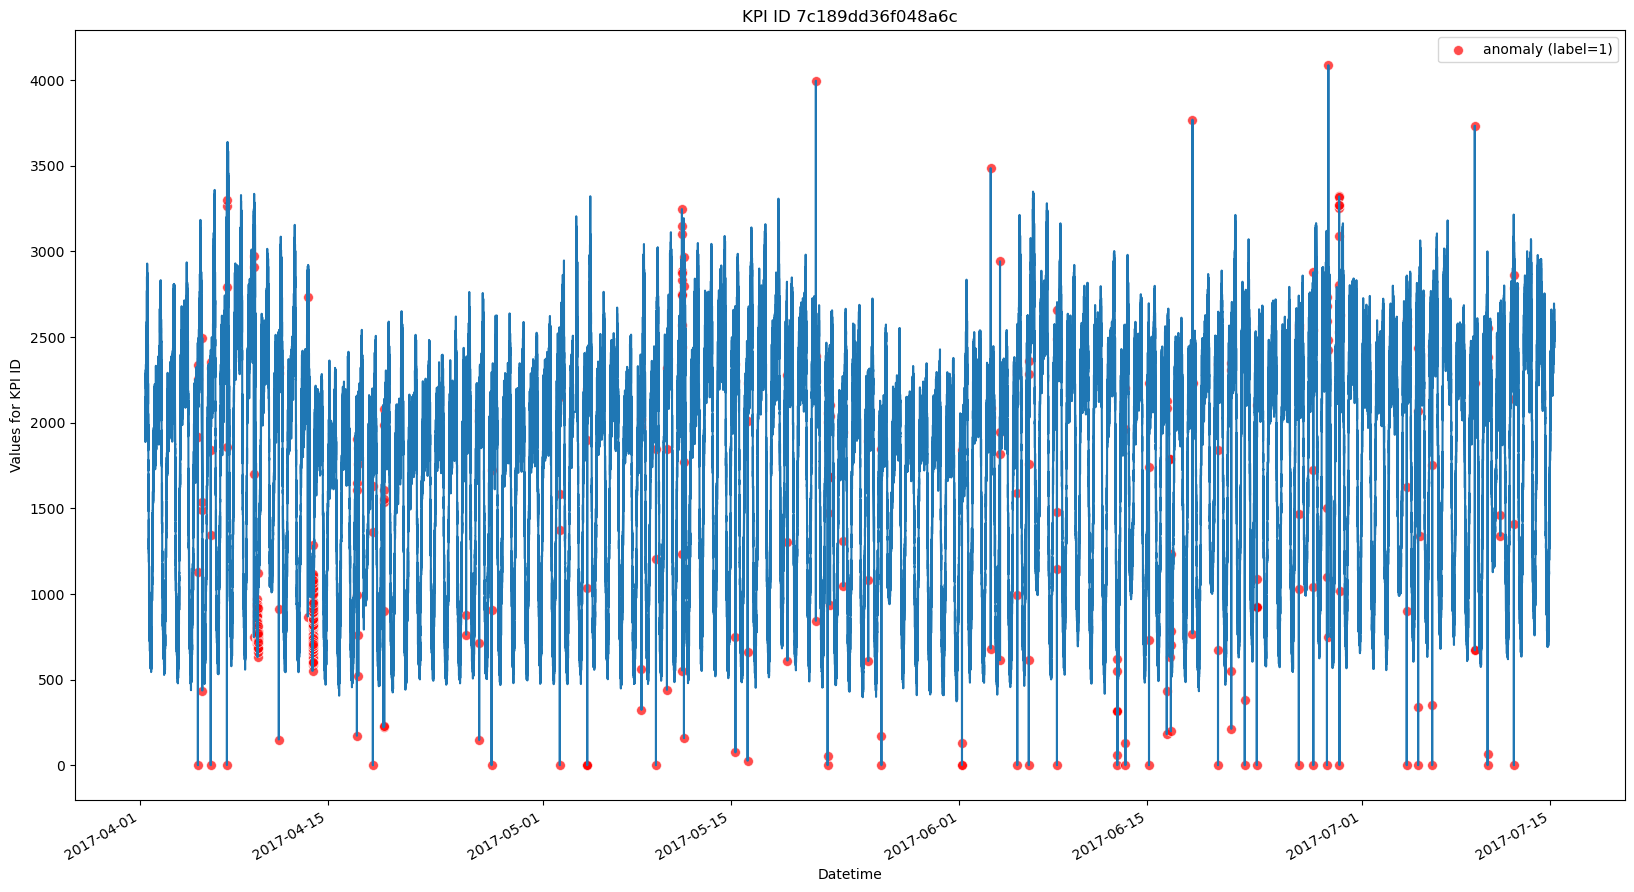

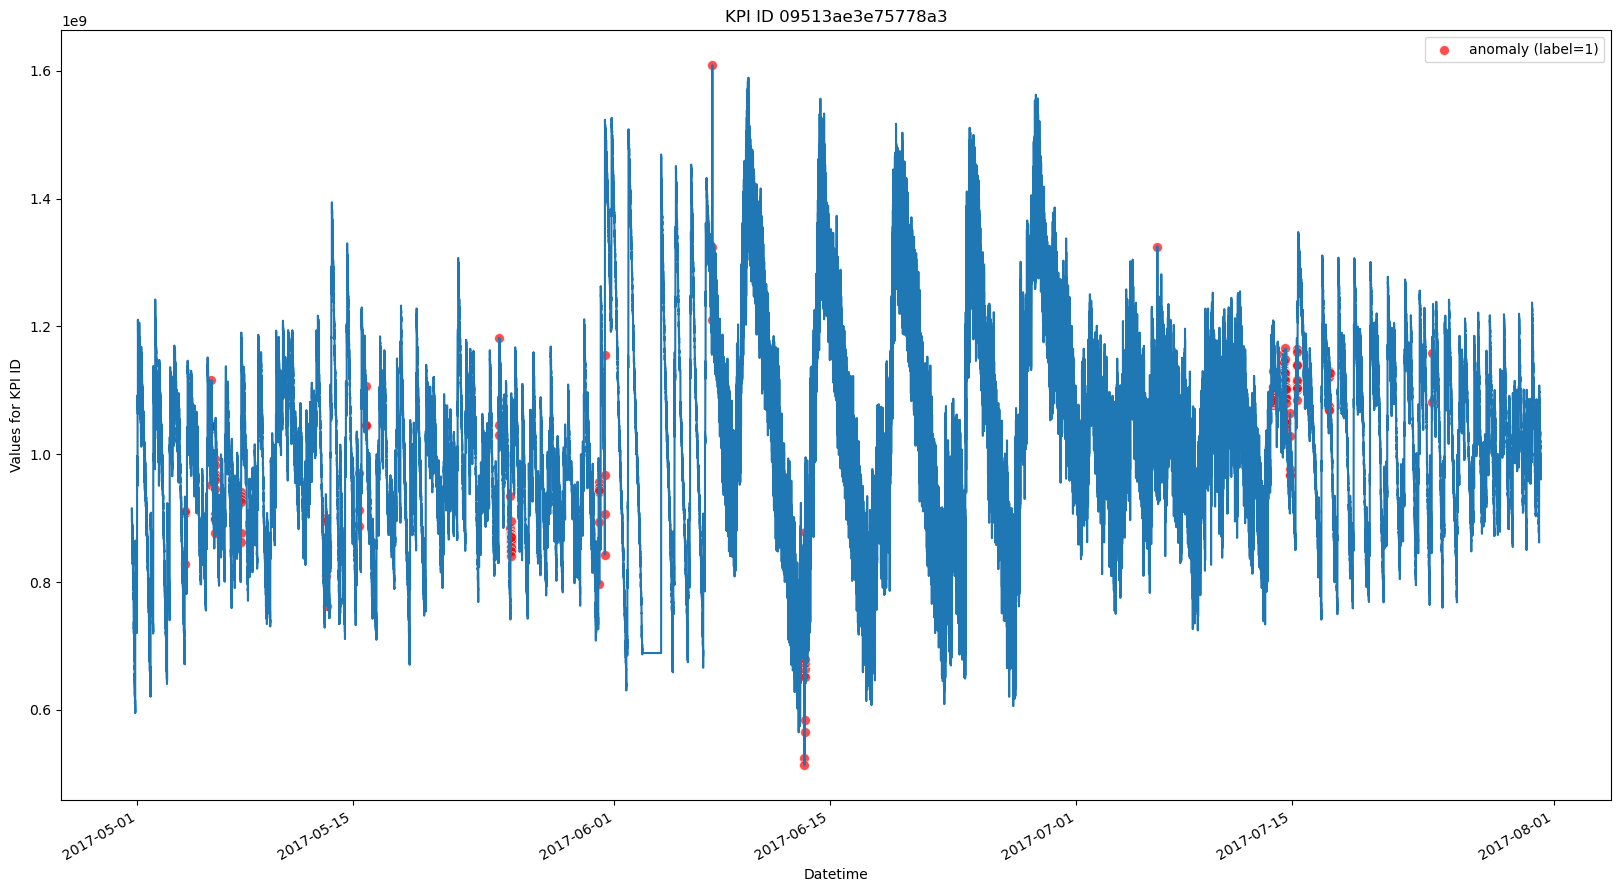

In [8]:
from utilities import plot_anomaly_labeled

KPI_IDs = ["18fbb1d5a5dc099d", "7c189dd36f048a6c", "09513ae3e75778a3"]
for KPI_ID in KPI_IDs:
    data = df_train[df_train.kpi_id == KPI_ID]
    plot_anomaly_labeled(data)

### Data Visulization

#### Stationarity

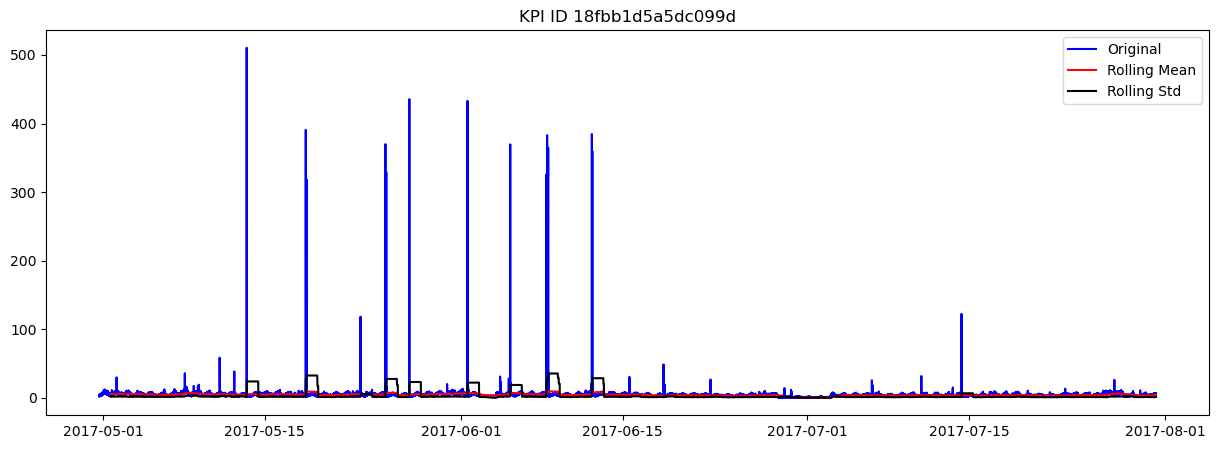

Results of Dickey Fuller Test:
Test Statistic                    -32.755889
p-value                             0.000000
#Lags Used                         71.000000
Number of Observations Used    131723.000000
Critical Value (1%)                -3.430400
Critical Value (5%)                -2.861562
Critical Value (10%)               -2.566782
dtype: float64
KPI ID 18fbb1d5a5dc099d is stationary


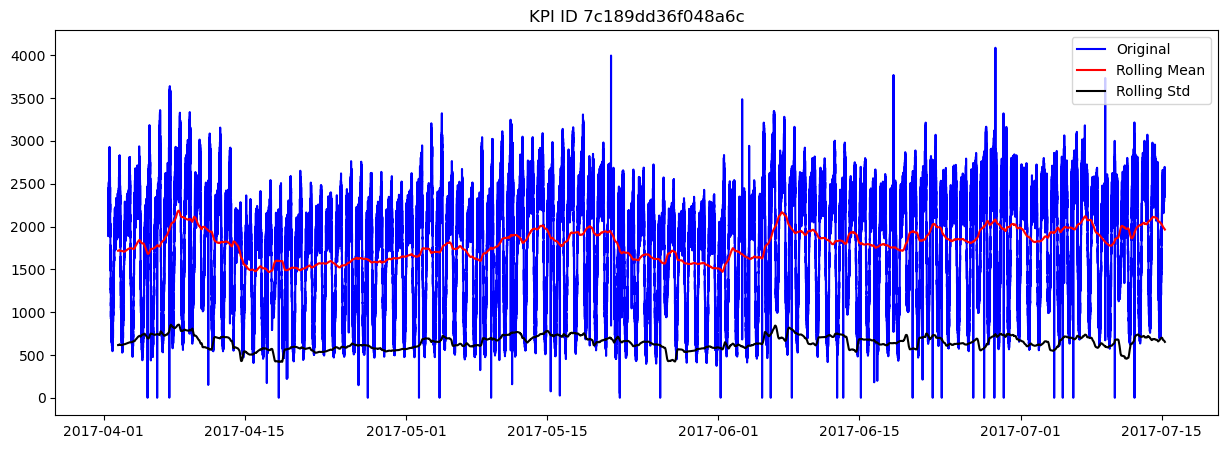

Results of Dickey Fuller Test:
Test Statistic                    -24.390016
p-value                             0.000000
#Lags Used                         75.000000
Number of Observations Used    150984.000000
Critical Value (1%)                -3.430393
Critical Value (5%)                -2.861559
Critical Value (10%)               -2.566780
dtype: float64
KPI ID 7c189dd36f048a6c is stationary


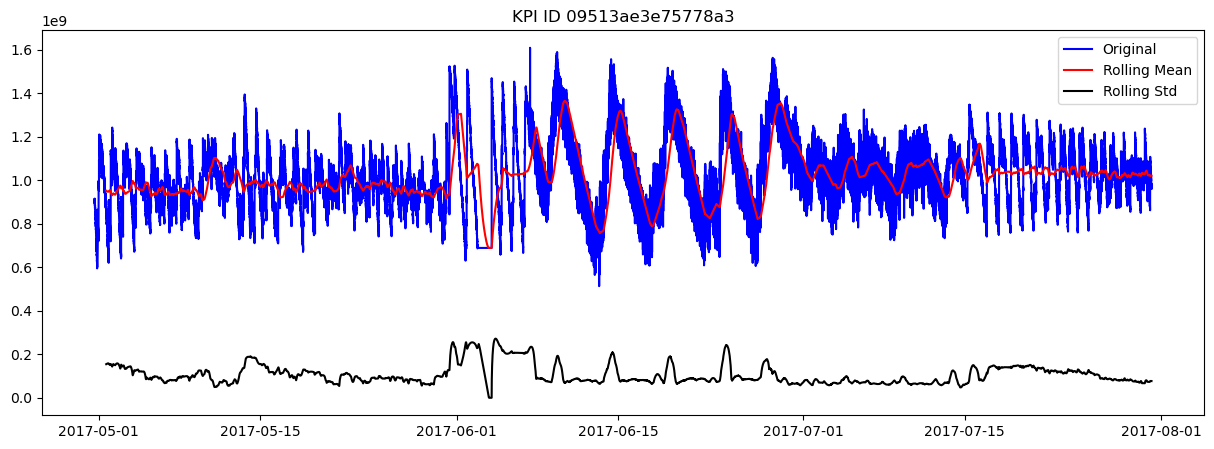

Results of Dickey Fuller Test:
Test Statistic                -1.045444e+01
p-value                        1.410628e-18
#Lags Used                     6.800000e+01
Number of Observations Used    1.317160e+05
Critical Value (1%)           -3.430400e+00
Critical Value (5%)           -2.861562e+00
Critical Value (10%)          -2.566782e+00
dtype: float64
KPI ID 09513ae3e75778a3 is stationary


In [14]:
from utilities import test_stationarity

for KPI_ID in KPI_IDs:
    data = df_train[df_train.kpi_id == KPI_ID]
    test_stationarity(data)

To determine if the dataset is stationary, we analyze the results of the Dickey-Fuller test, which include three key values: the Test Statistic, the p-value, and the Critical Values. The first two results show a p-value of 0 and a strongly negative Test Statistic, indicating a very low probability of the null hypothesis being true. For the third value, the p-value is also close to 0, and the Test Statistic is much lower than the critical values at all significance levels, further supporting the rejection of the null hypothesis.

Additionally, the stationary test shows that the rolling mean and standard deviation are nearly parallel to the x-axis, with the exception of the third value. The Dickey-Fuller test provides a clear conclusion: the data is stationary, as indicated by the significantly negative Test Statistic and a p-value less than 0.05. Therefore, no further transformation of the data is necessary for forward modeling.

#### Seasonality

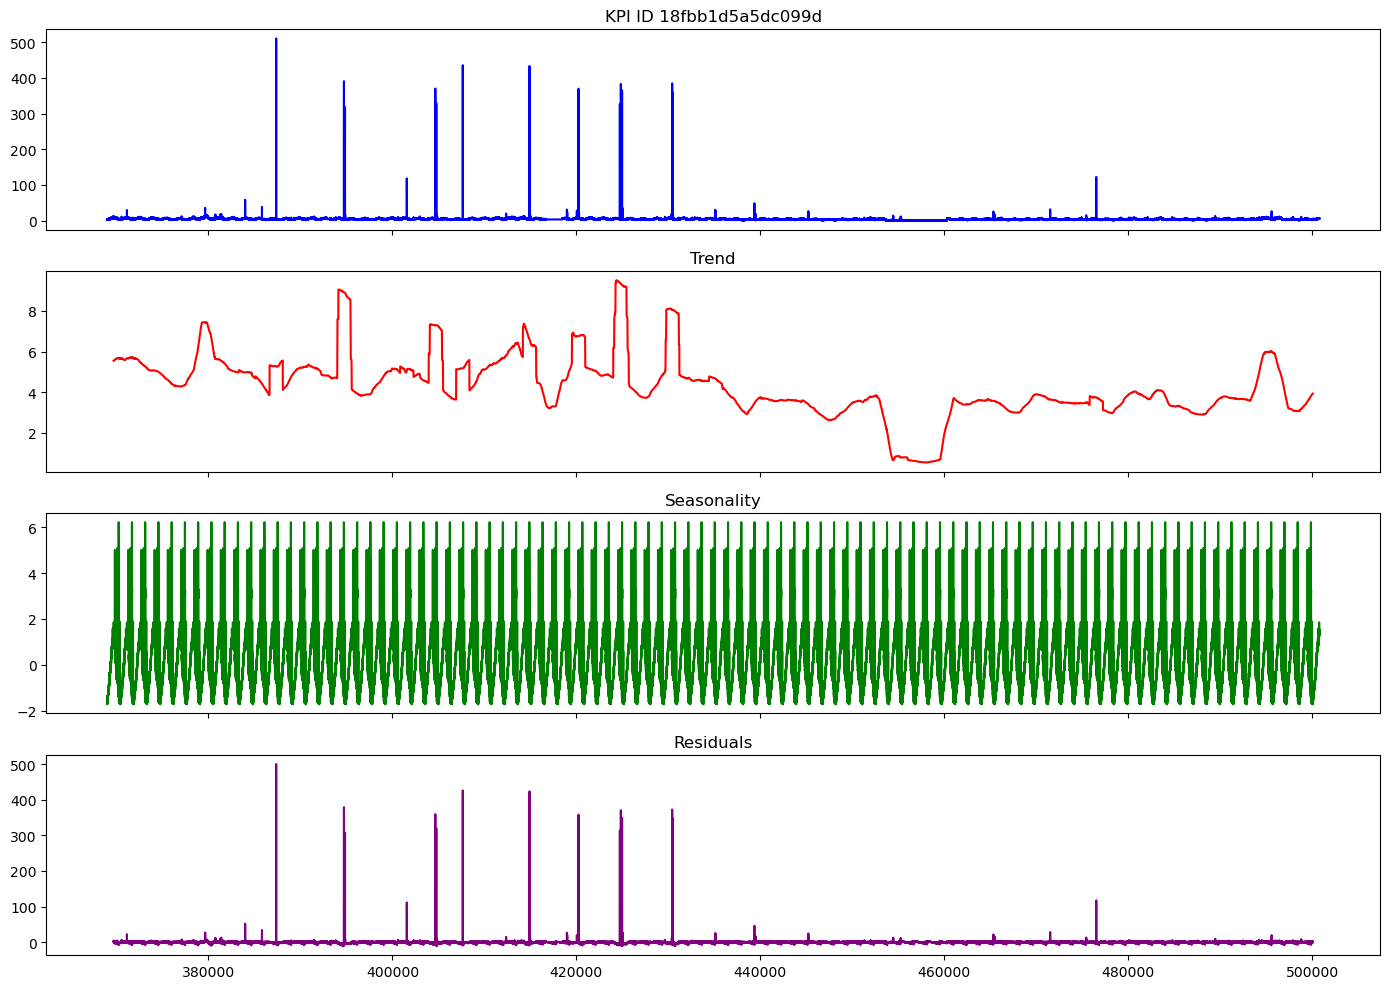

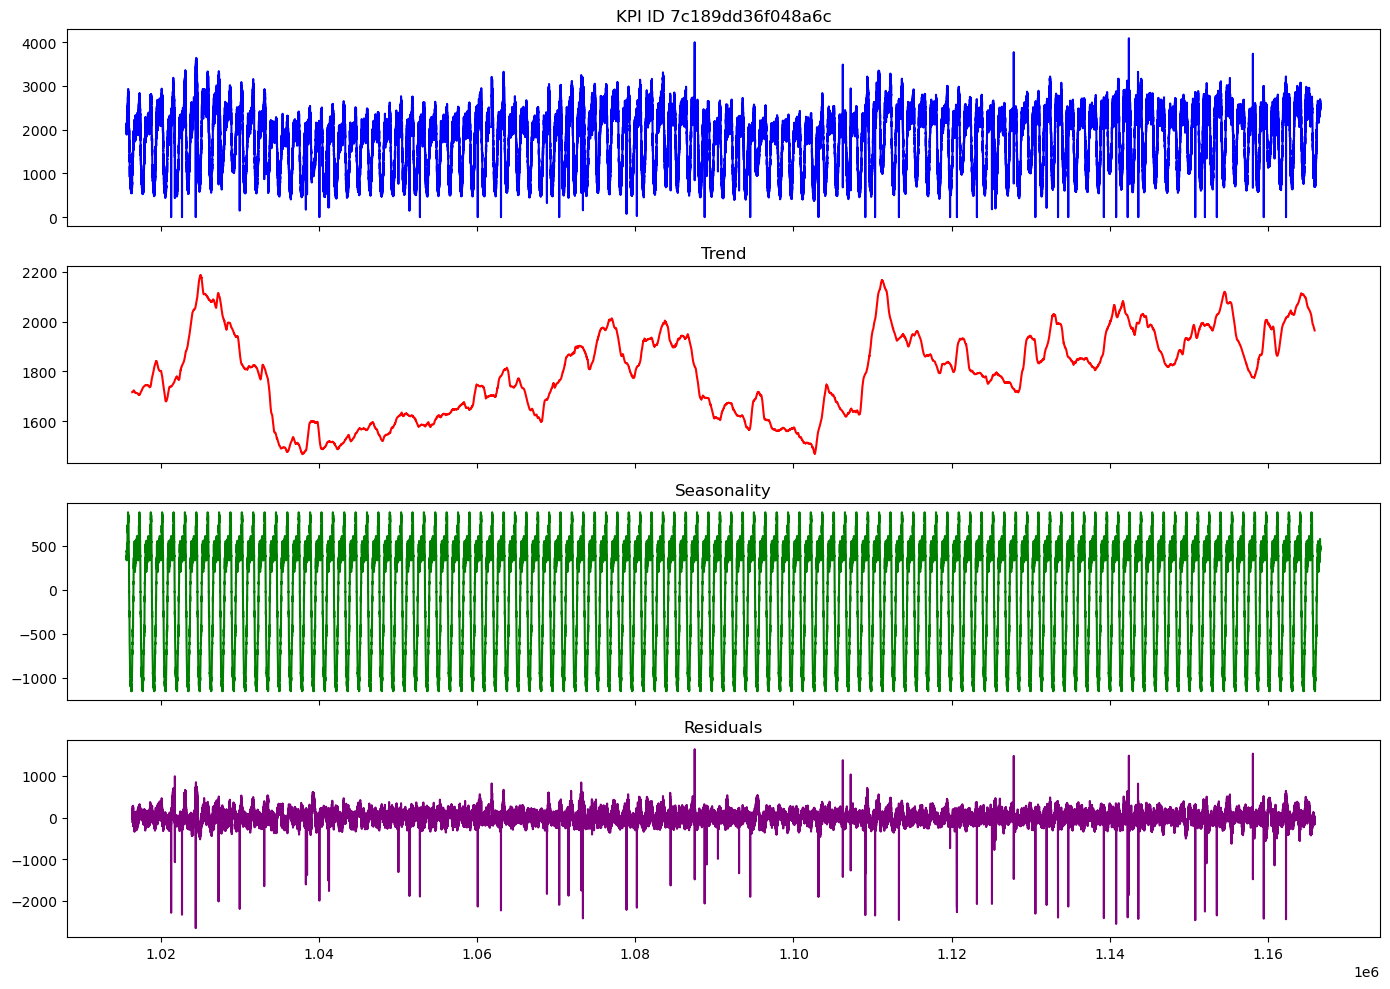

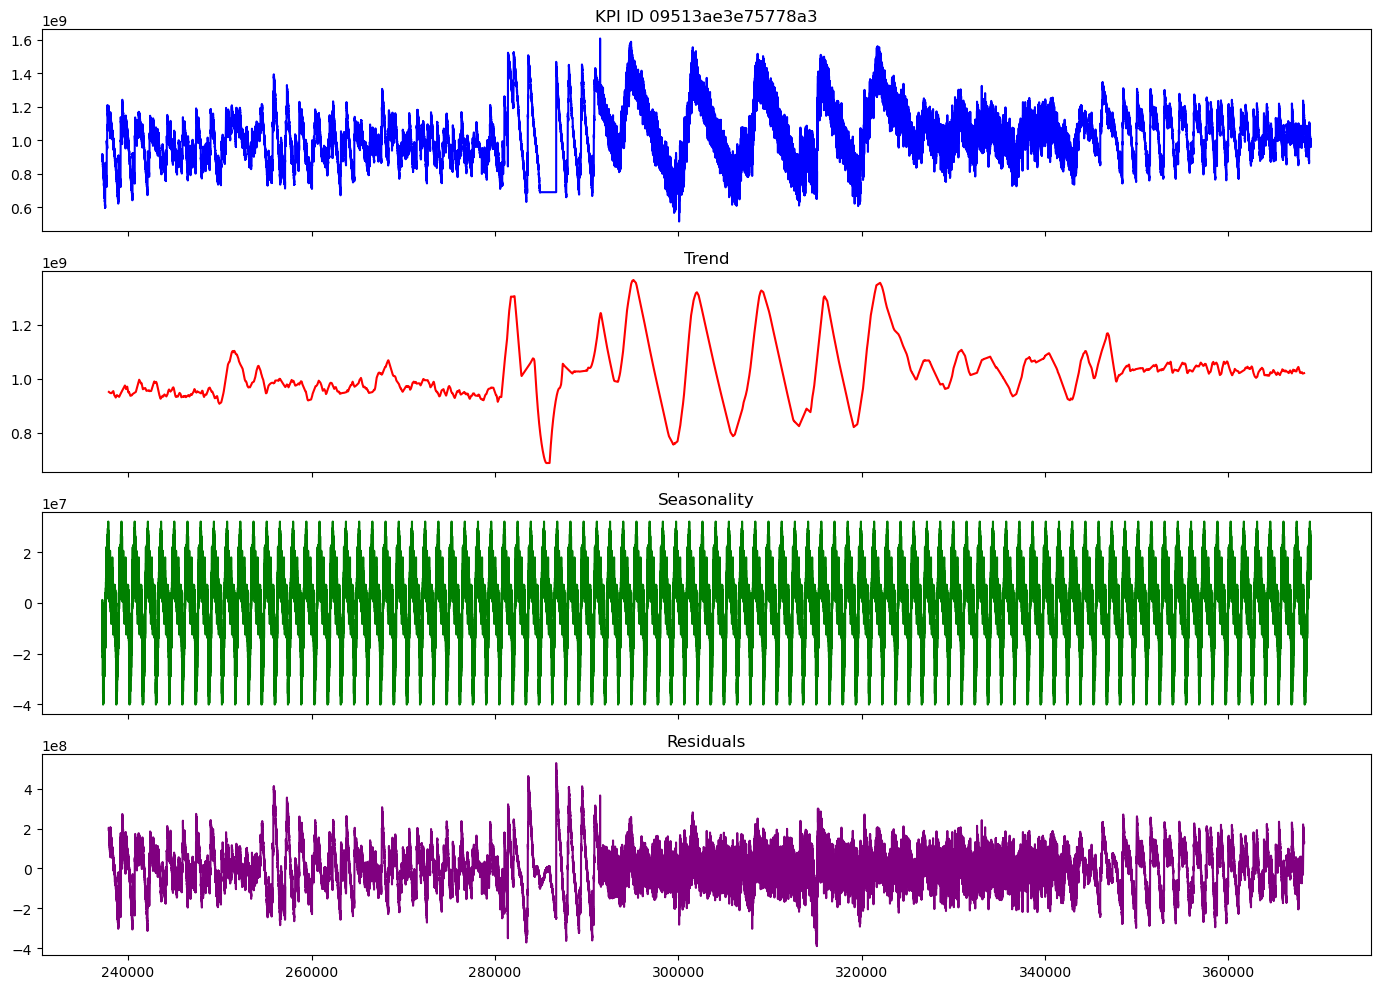

In [15]:
from utilities import season_decompose

for KPI_ID in KPI_IDs:
    data = df_train[df_train.kpi_id == KPI_ID]
    trend, seasonal, residual = season_decompose(data)

From the seasonality analysis, our data has a strong seasonality. Stationarity refers to the overall statistical properties being constant over time, whereas seasonality refers to periodic patterns within the data. The presence of seasonality does not contradict stationarity if the seasonal patterns are regular and predictable.

#### ACF & PACF

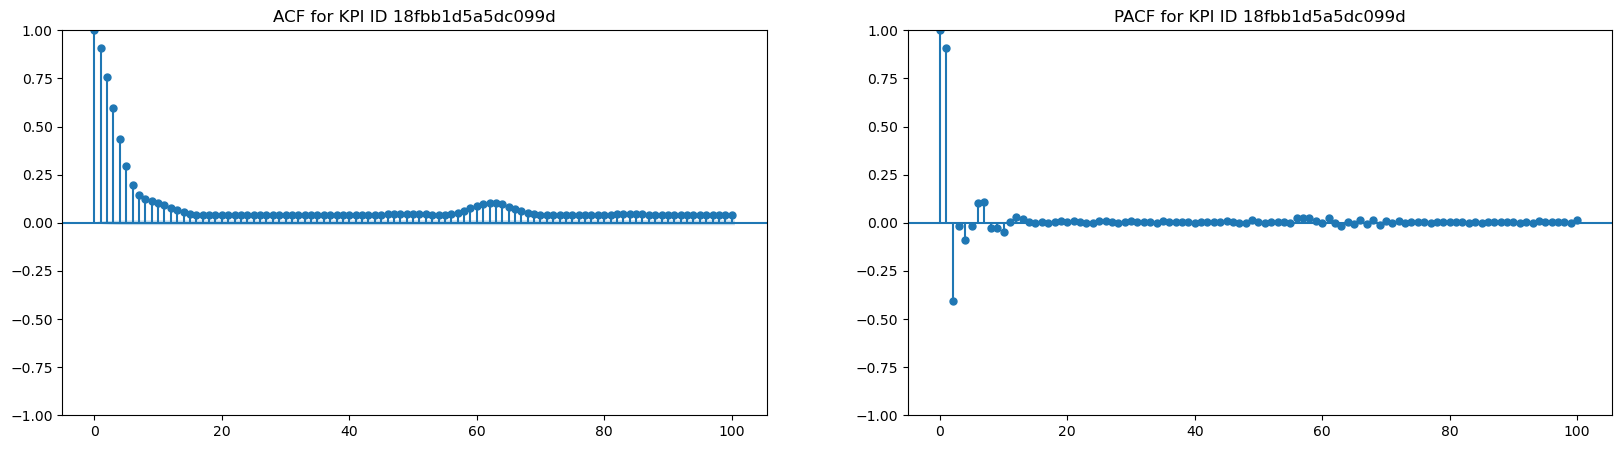

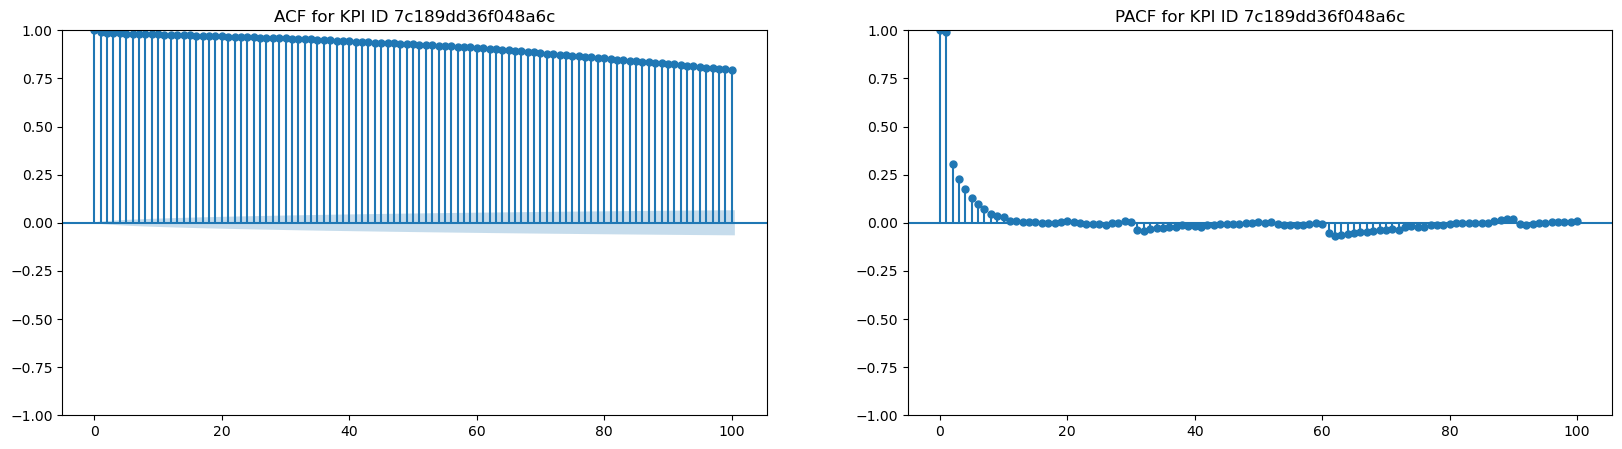

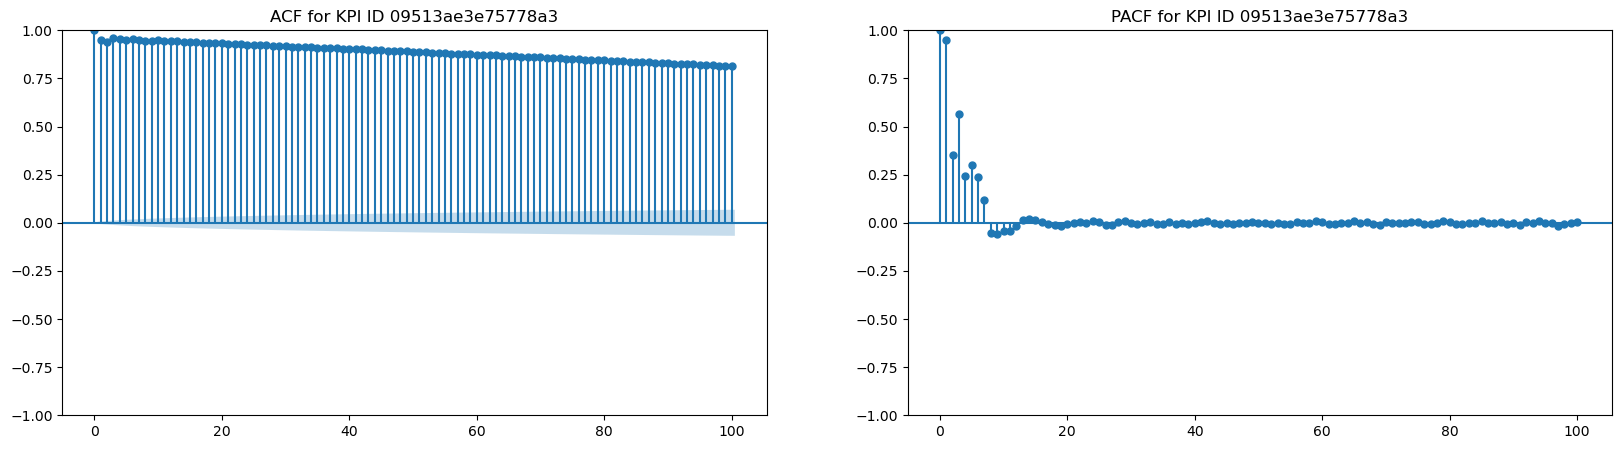

In [16]:
from utilities import plot_acf_pacf

for KPI_ID in KPI_IDs:
    data = df_train[df_train.kpi_id == KPI_ID]
    plot_acf_pacf(data)

The ACF showed a slowly decaying pattern, while the PACF cuts off more sharply. This combination typically suggests an autoregressive (AR) process is more appropriate than a moving average (MA) process.

## Anomaly Detection

### Heuristics based STL Decomposition

The heuristic method we choose here is the robust Z-score method based on MAD, Median Absolute Deviation.

Reference:

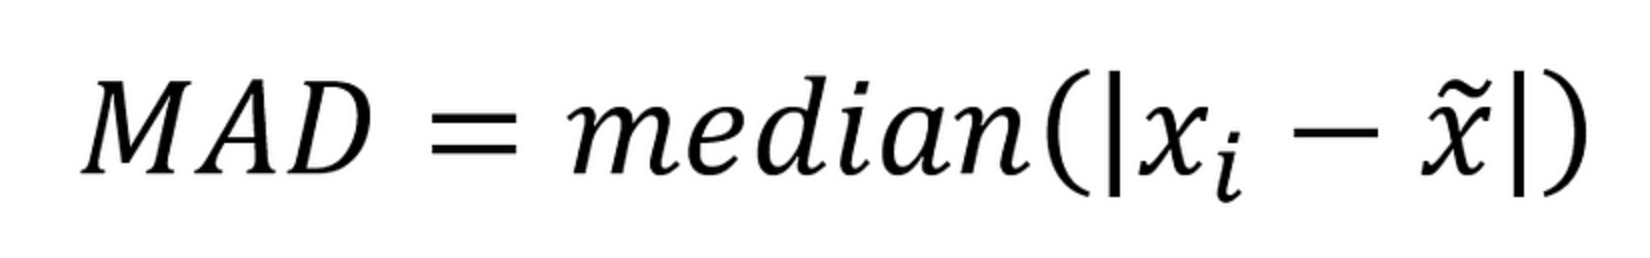
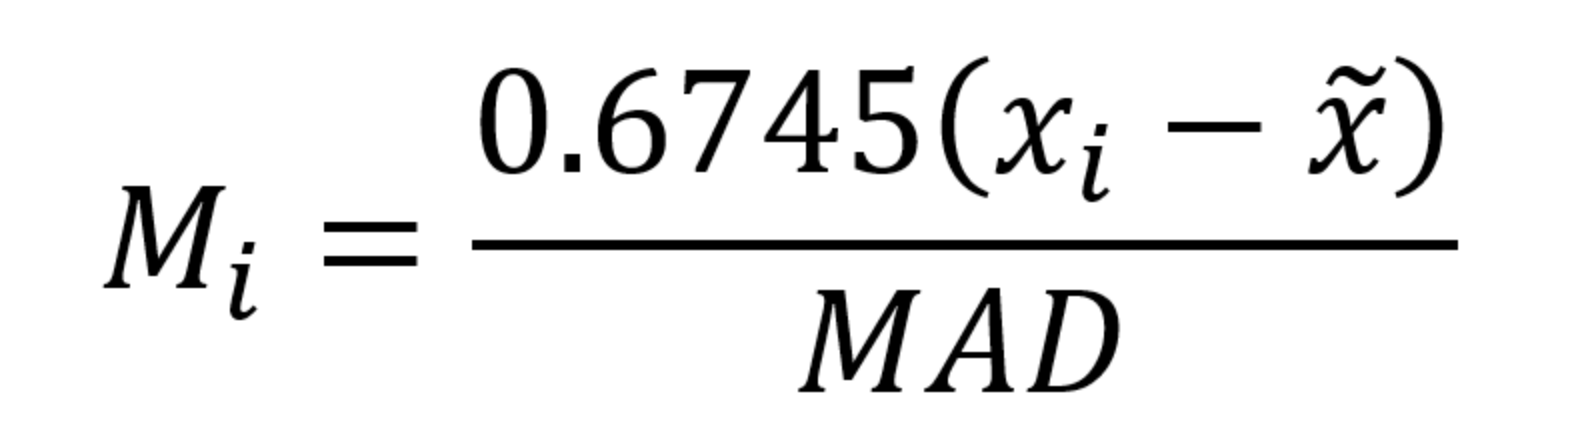

Confusion matrix:
True Positive: 123417
False Positive: 513
False Negative: 7625
True Negative: 240
False Positive Rate: 68.13%
False Negative Rate: 5.82%
Accuracy: 93.83%
F1 Score: 5.57%
Recall: 3.05%
Precision: 31.87%


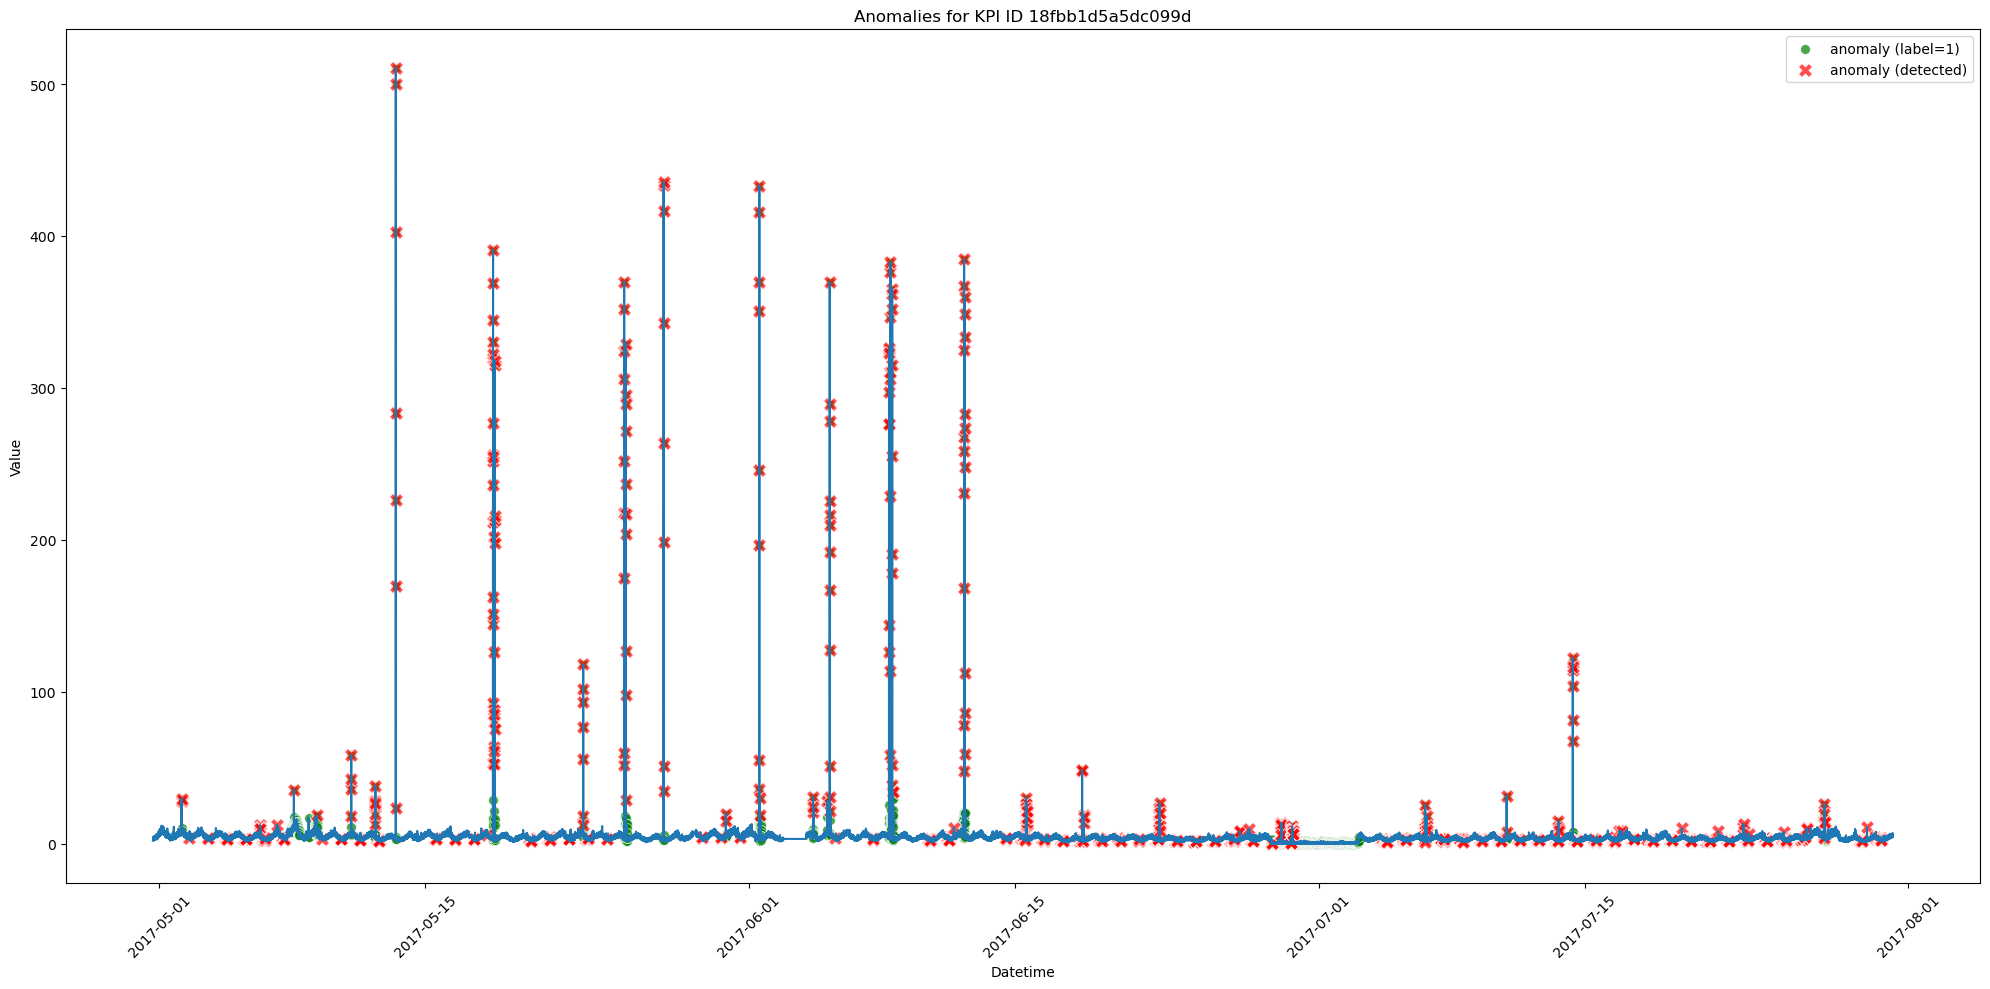

Confusion matrix:
True Positive: 150617
False Positive: 1
False Negative: 338
True Negative: 104
False Positive Rate: 0.95%
False Negative Rate: 0.22%
Accuracy: 99.78%
F1 Score: 38.03%
Recall: 23.53%
Precision: 99.05%


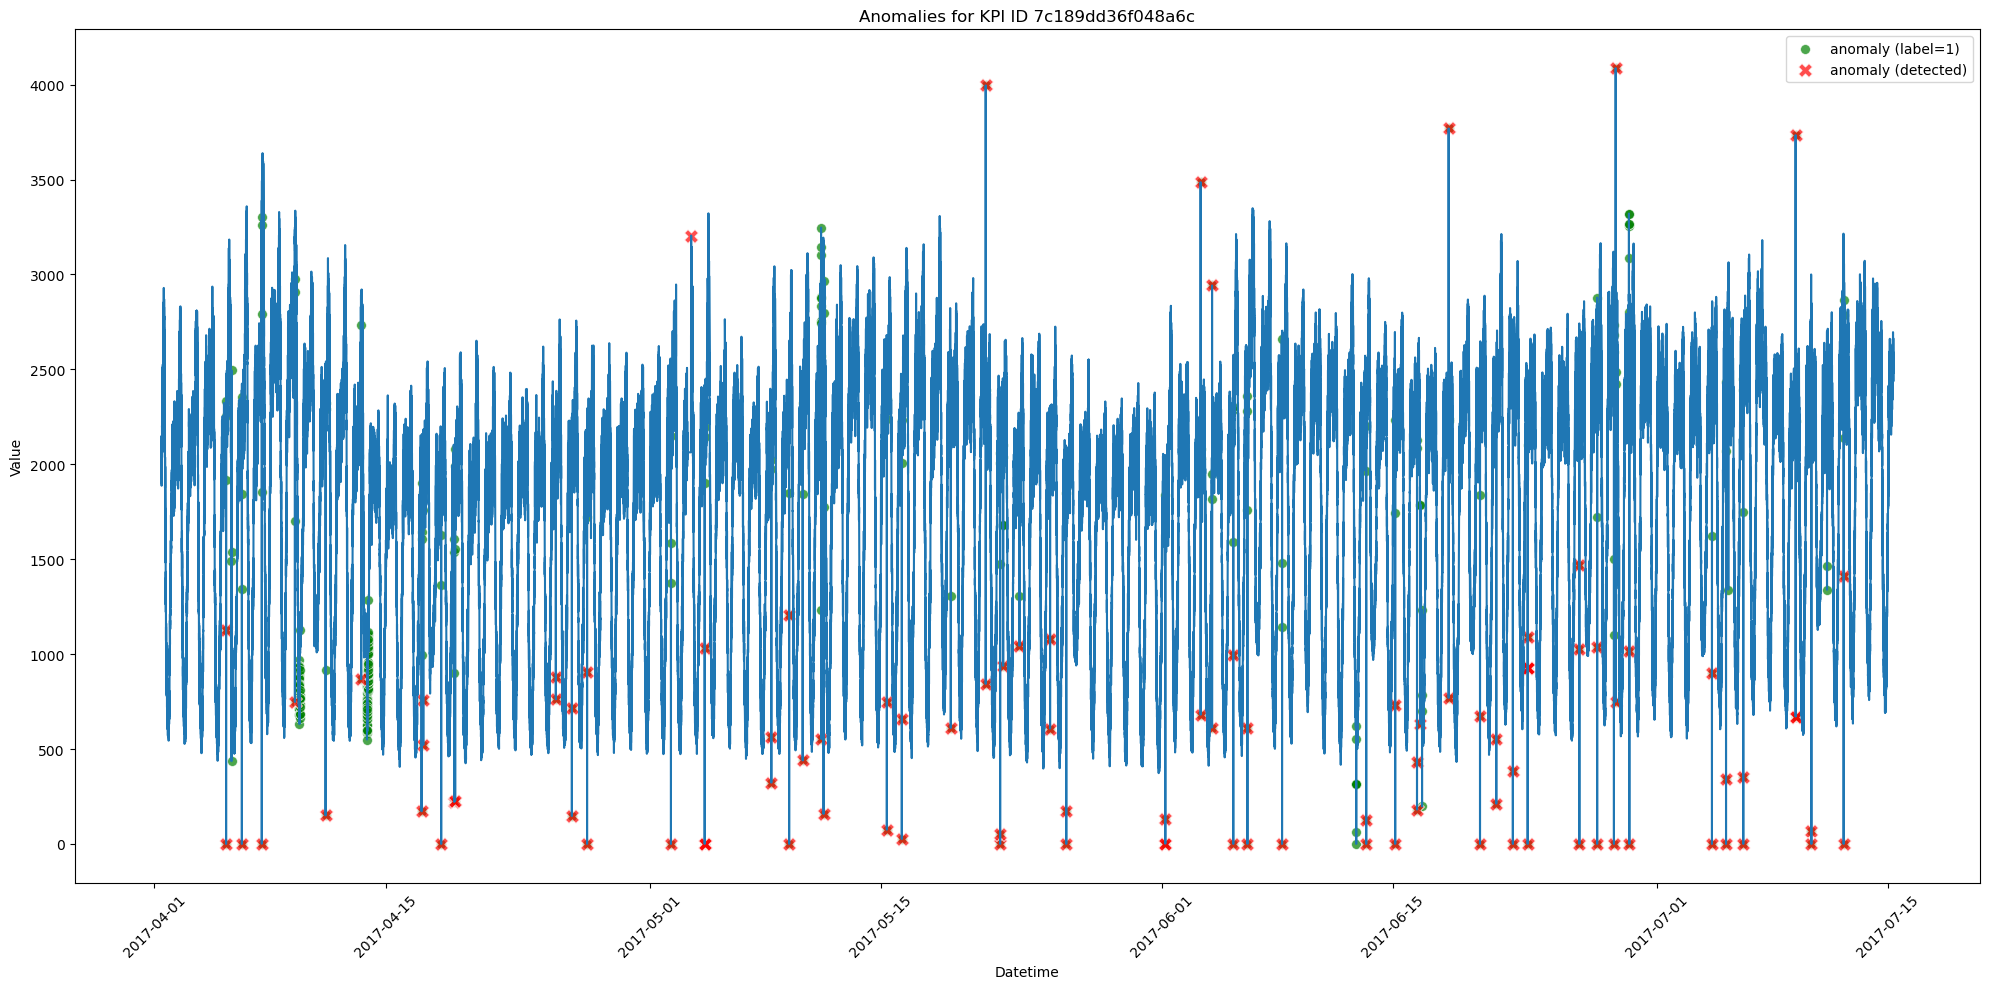

Confusion matrix:
True Positive: 131448
False Positive: 88
False Negative: 249
True Negative: 0
False Positive Rate: 100.0%
False Negative Rate: 0.19%
Accuracy: 99.74%
F1 Score: 0.00%
Recall: 0.00%
Precision: 0.00%


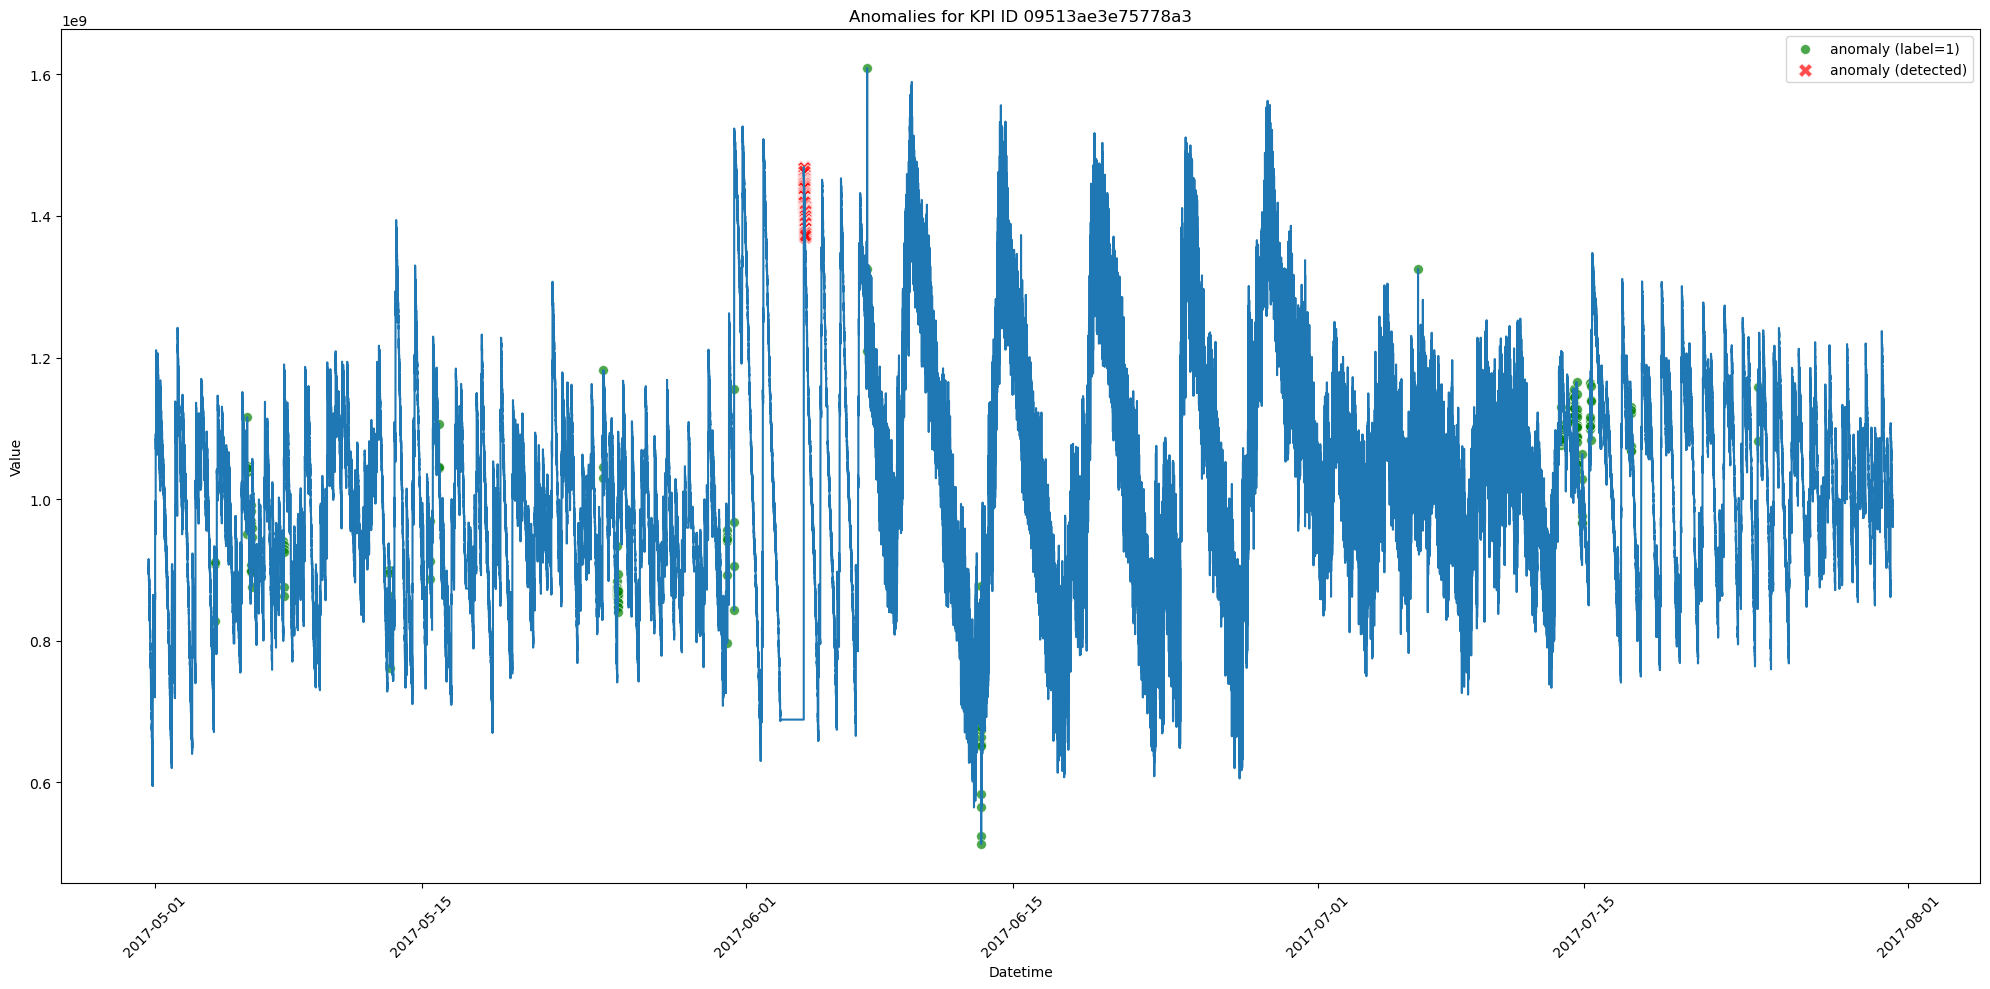

In [9]:
from model import STL_decompose

eval_dict = {}
for KPI_ID in KPI_IDs:
    data = df_train[df_train.kpi_id == KPI_ID]
    anomalies, eval_df = STL_decompose(
        data, threshold=8, window_size=1440, use_median=True
    )
    eval_dict[KPI_ID] = eval_df.reset_index(drop=True)

 The result metrics shows that robust Z-score achieves a high accuracy but the false positive rate is also high. That suggests that the approach is highly sensitive to detect the anomalies. From the plots above, this approach is good at detecting the anomalies which has the extreme value.

Based on the second graph, if the dataset is stable, which can be found the trend or kind of regularity, STL is good at finding the extreme value or the value not include in this trend. But for the larger vibration which not that stable dataset, we could see that its detective ability is decreasing. Because of the vibration is larger in the middle so that it can find a lot of abnomalies on this period. But for the beginning and the ending, due to the effect of the middle part makes STL hard to detect abnomalies which has exceed its range.

For the first and third graphs, especially the third graph that the FPR almost arrived at 100% which means that the model does not have the ability to detect normal values and abnomalies. In our case, it is better to adjust the decomposition parameters of the STL or introduce more features to enhance the generalisation of the model but because we do not have other features to add. It still need test to check which parameters can perform the best. 

### GMM

To determine whether a data point is an anomaly we need to compute the log-likelihood of the given data.

We use the "score" method of GMM to compute the per-sample average log-likelihood of the data.

Then, compare the likelihood values with the density threshold.

we identify the outliers using the first percentile lowest density as the threshold. I.e., approximately 1% of the instances will be flagged as anomalies.

Confusion matrix:
True Positive: 123301
False Positive: 629
False Negative: 7176
True Negative: 689
False Positive Rate: 47.72%
False Negative Rate: 5.5%
Accuracy: 94.08%
F1 Score: 15.01%
Recall: 8.76%
Precision: 52.28%


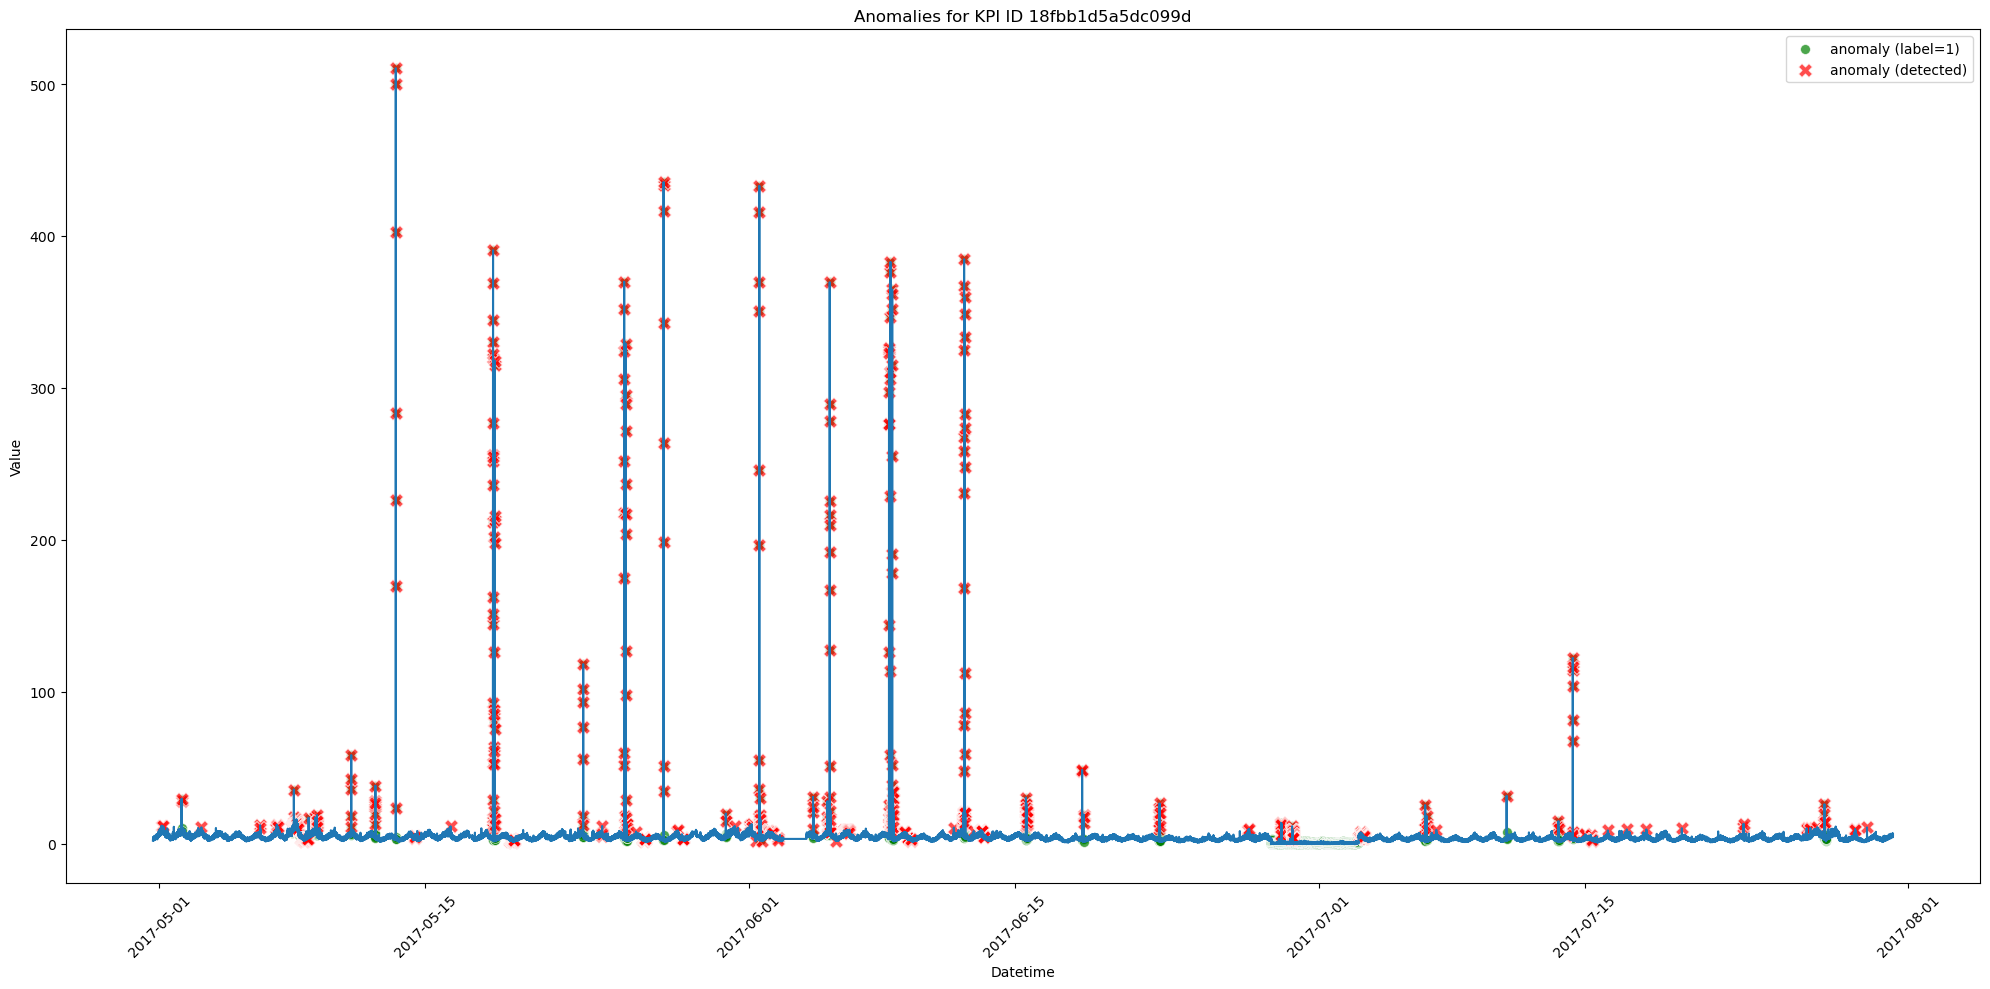

Confusion matrix:
True Positive: 149153
False Positive: 1465
False Negative: 396
True Negative: 46
False Positive Rate: 96.96%
False Negative Rate: 0.26%
Accuracy: 98.77%
F1 Score: 4.71%
Recall: 10.41%
Precision: 3.04%


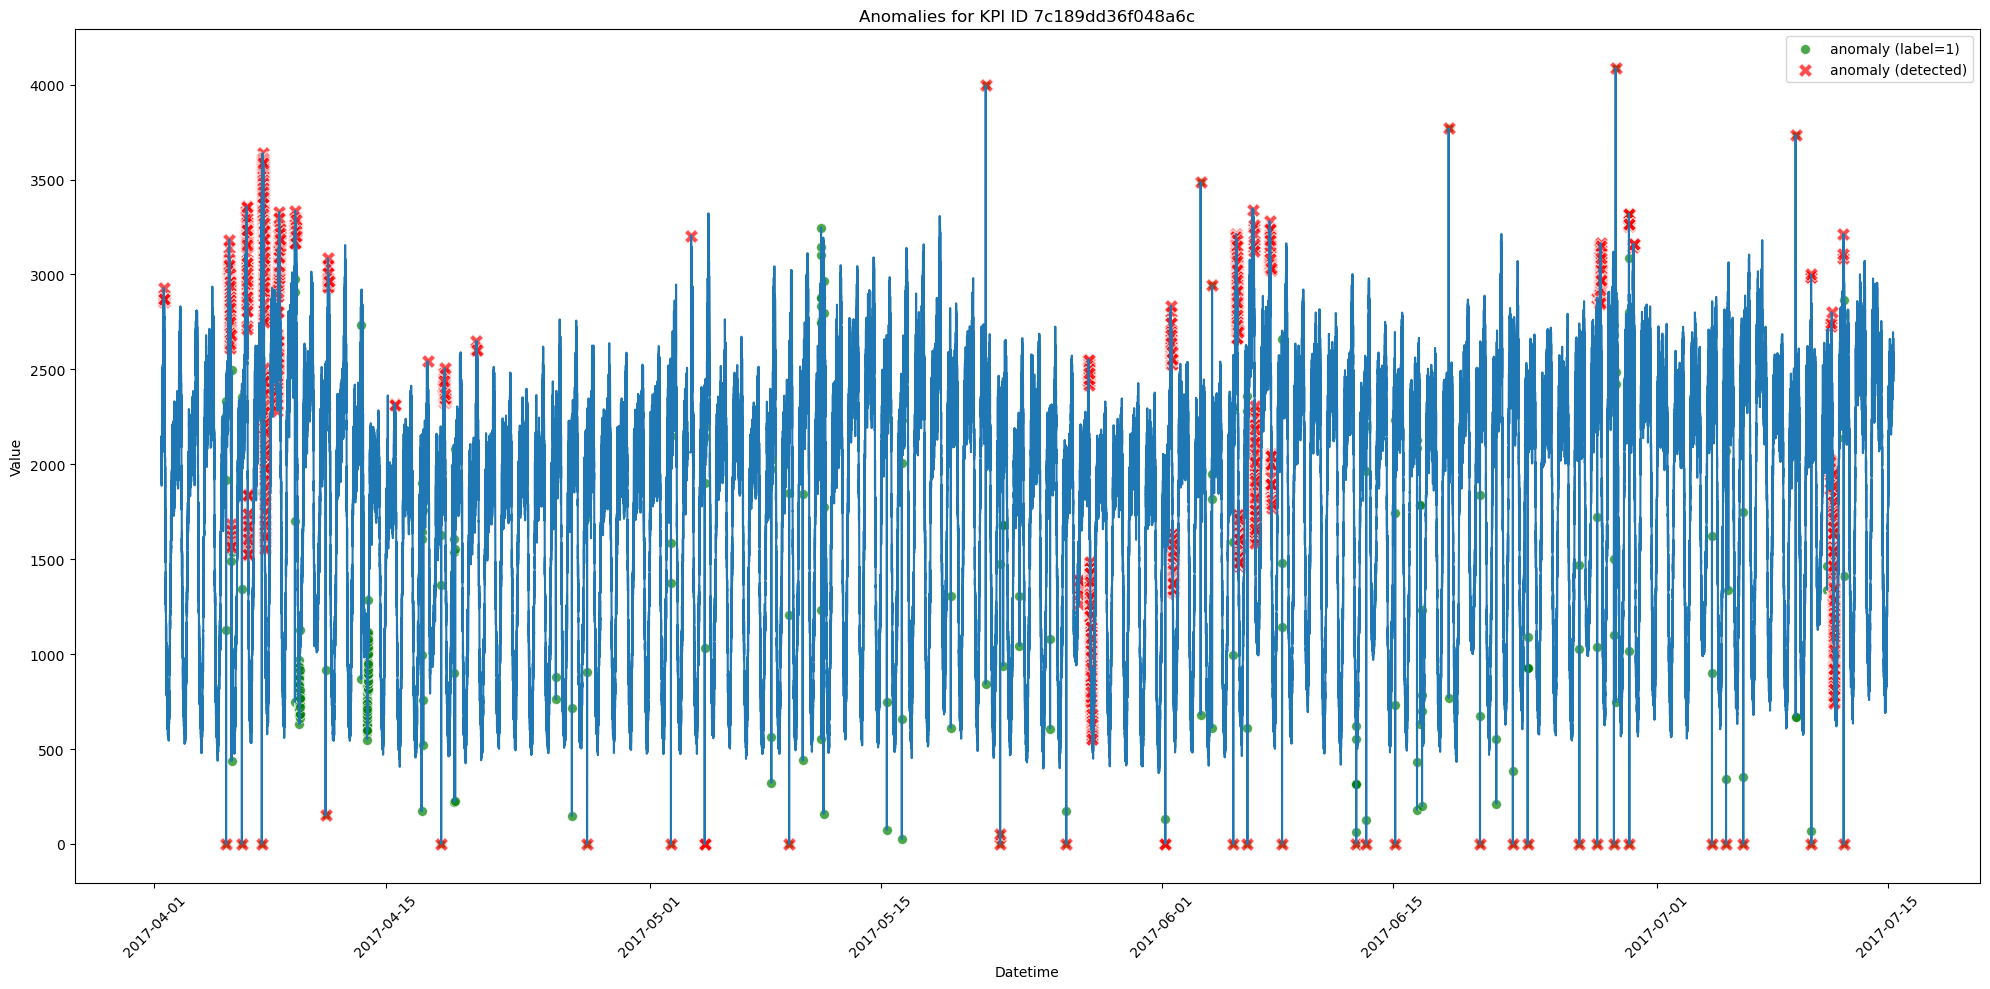

Confusion matrix:
True Positive: 130222
False Positive: 1314
False Negative: 245
True Negative: 4
False Positive Rate: 99.7%
False Negative Rate: 0.19%
Accuracy: 98.82%
F1 Score: 0.51%
Recall: 1.61%
Precision: 0.30%


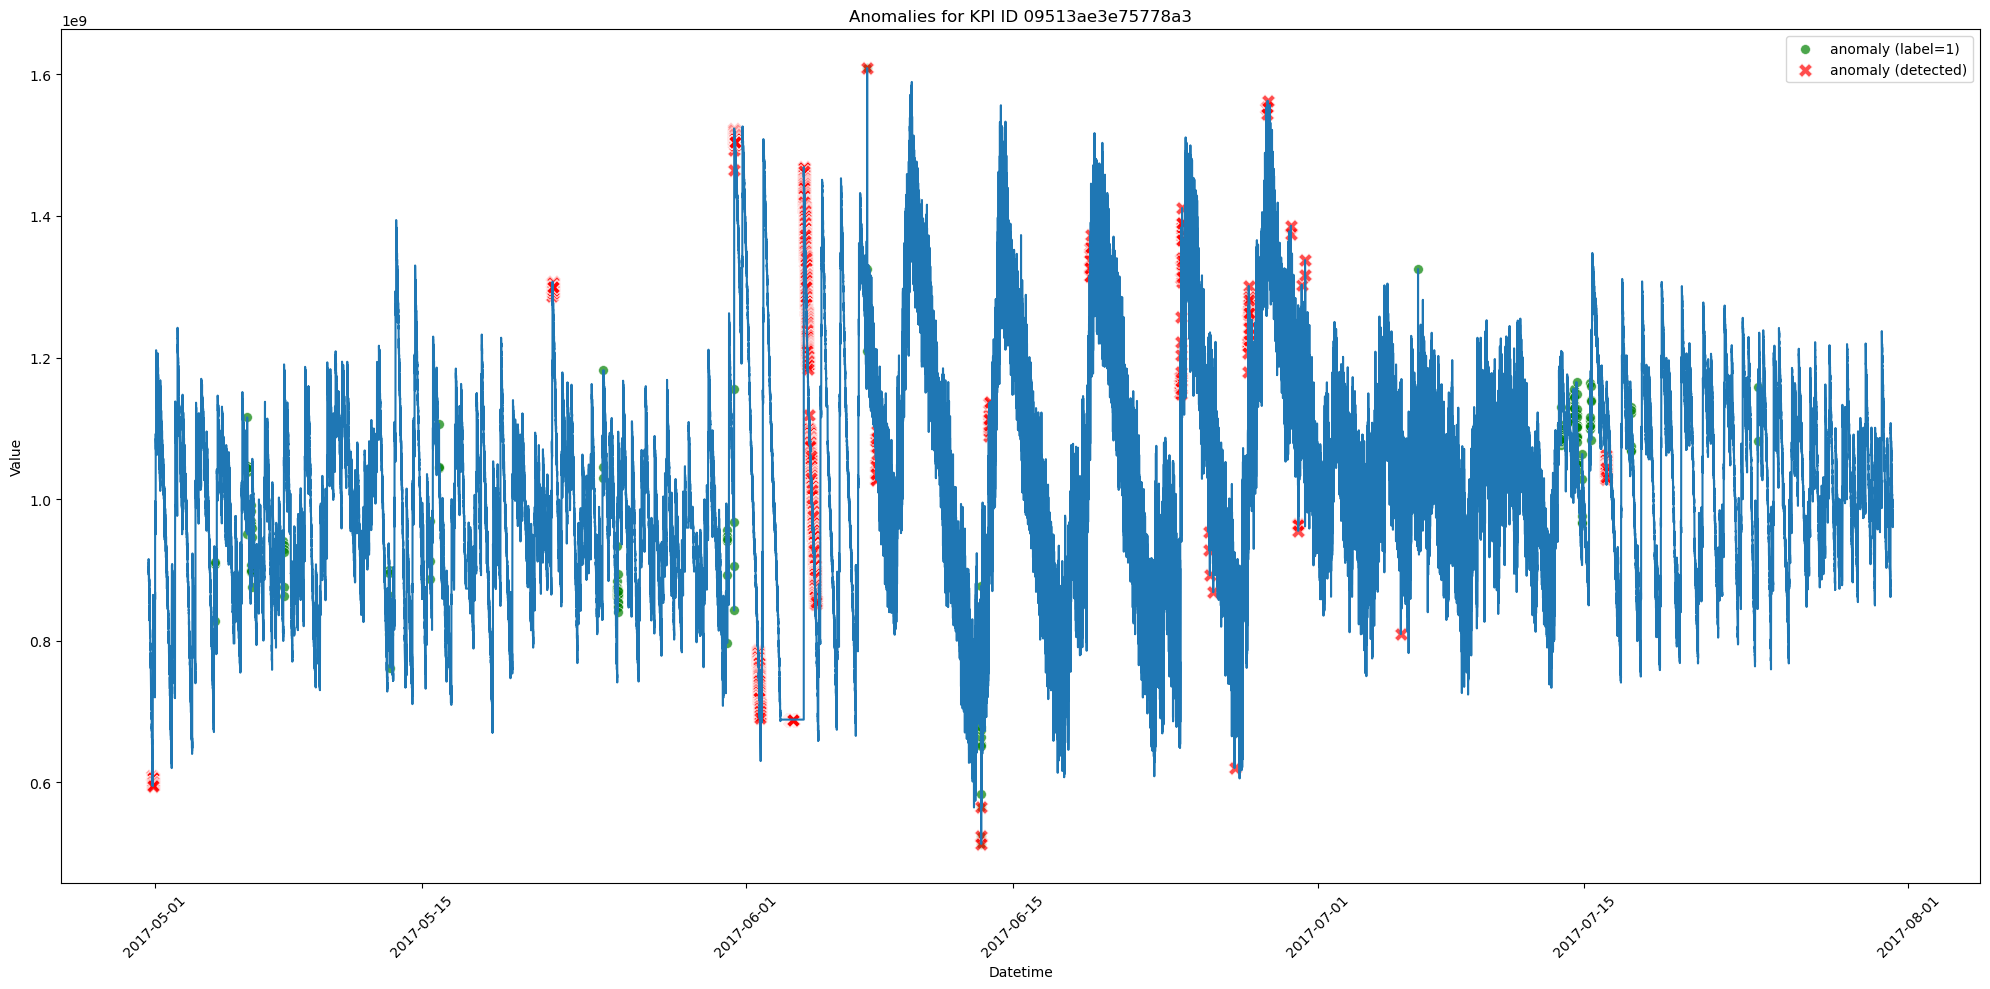

In [10]:
from model import GMM_detection

for KPI_ID in KPI_IDs:
    data = df_train[df_train.kpi_id == KPI_ID]
    data["rolling_mean"] = data["value"].rolling(window=1440).mean()
    data["rolling_std"] = data["value"].rolling(window=1440).std()

    anomalies, eval_df = GMM_detection(
        data,
        n_components=10,
        sensity=0.01,
        feature_columns=["value", "rolling_mean", "rolling_std"],
    )

    eval_dict[KPI_ID] = pd.concat([eval_dict[KPI_ID], eval_df.reset_index(drop=True)])

The Gaussian Mixture Model is also sentive to the anomalies, but in terms of the performance of the fist type of data, it is better than the rest. But for the low value anomaly, it can't detect them

For GMM, comparing with traditional Z-score method, it is better to handle with the unsymmetrical dataset. For the first one, it has 52.28% in precision which is much better than second and third 3.04% and 0.3%. This means even model has detected a lot of abnomalies it actually contains a lot of normal values. The high value of FPR also prove this problem. To solve this problem, we could change the parameters but the main problem is GMM is not good at dealing with second and third dataset. It is better to combine with different anomaly detection algorithm so that the test will be more comprehensive. 

### LSTM Autoencoder

The Autoencoder's job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

In [20]:
import torch


def train(model, train_loader, val_loader, device="mps", epochs=5, learning_rate=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss = loss_fn(outputs, batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                outputs = model(batch)
                loss = loss_fn(outputs, batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(
            f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

    return train_losses, val_losses

In [21]:
def compute_errors(model, dataset, device):
    model.eval()
    errors = []
    with torch.no_grad():
        for idx in range(len(dataset)):
            sequence = dataset[idx].unsqueeze(0).to(device)
            reconstructed_sequence = model(sequence)
            reconstruction_error = torch.mean(
                (sequence - reconstructed_sequence) ** 2
            ).item()
            errors.append(reconstruction_error)
    return errors

Epoch [1/5], Train Loss: 0.2203, Val Loss: 0.0176
Epoch [2/5], Train Loss: 0.0070, Val Loss: 0.0042
Epoch [3/5], Train Loss: 0.0025, Val Loss: 0.0018
Epoch [4/5], Train Loss: 0.0018, Val Loss: 0.0016
Epoch [5/5], Train Loss: 0.0014, Val Loss: 0.0010
Confusion matrix:
True Positive: 118351
False Positive: 5579
False Negative: 6854
True Negative: 1011
False Positive Rate: 84.66%
False Negative Rate: 5.47%
Accuracy: 90.57%
F1 Score: 13.99%
Recall: 12.85%
Precision: 15.34%


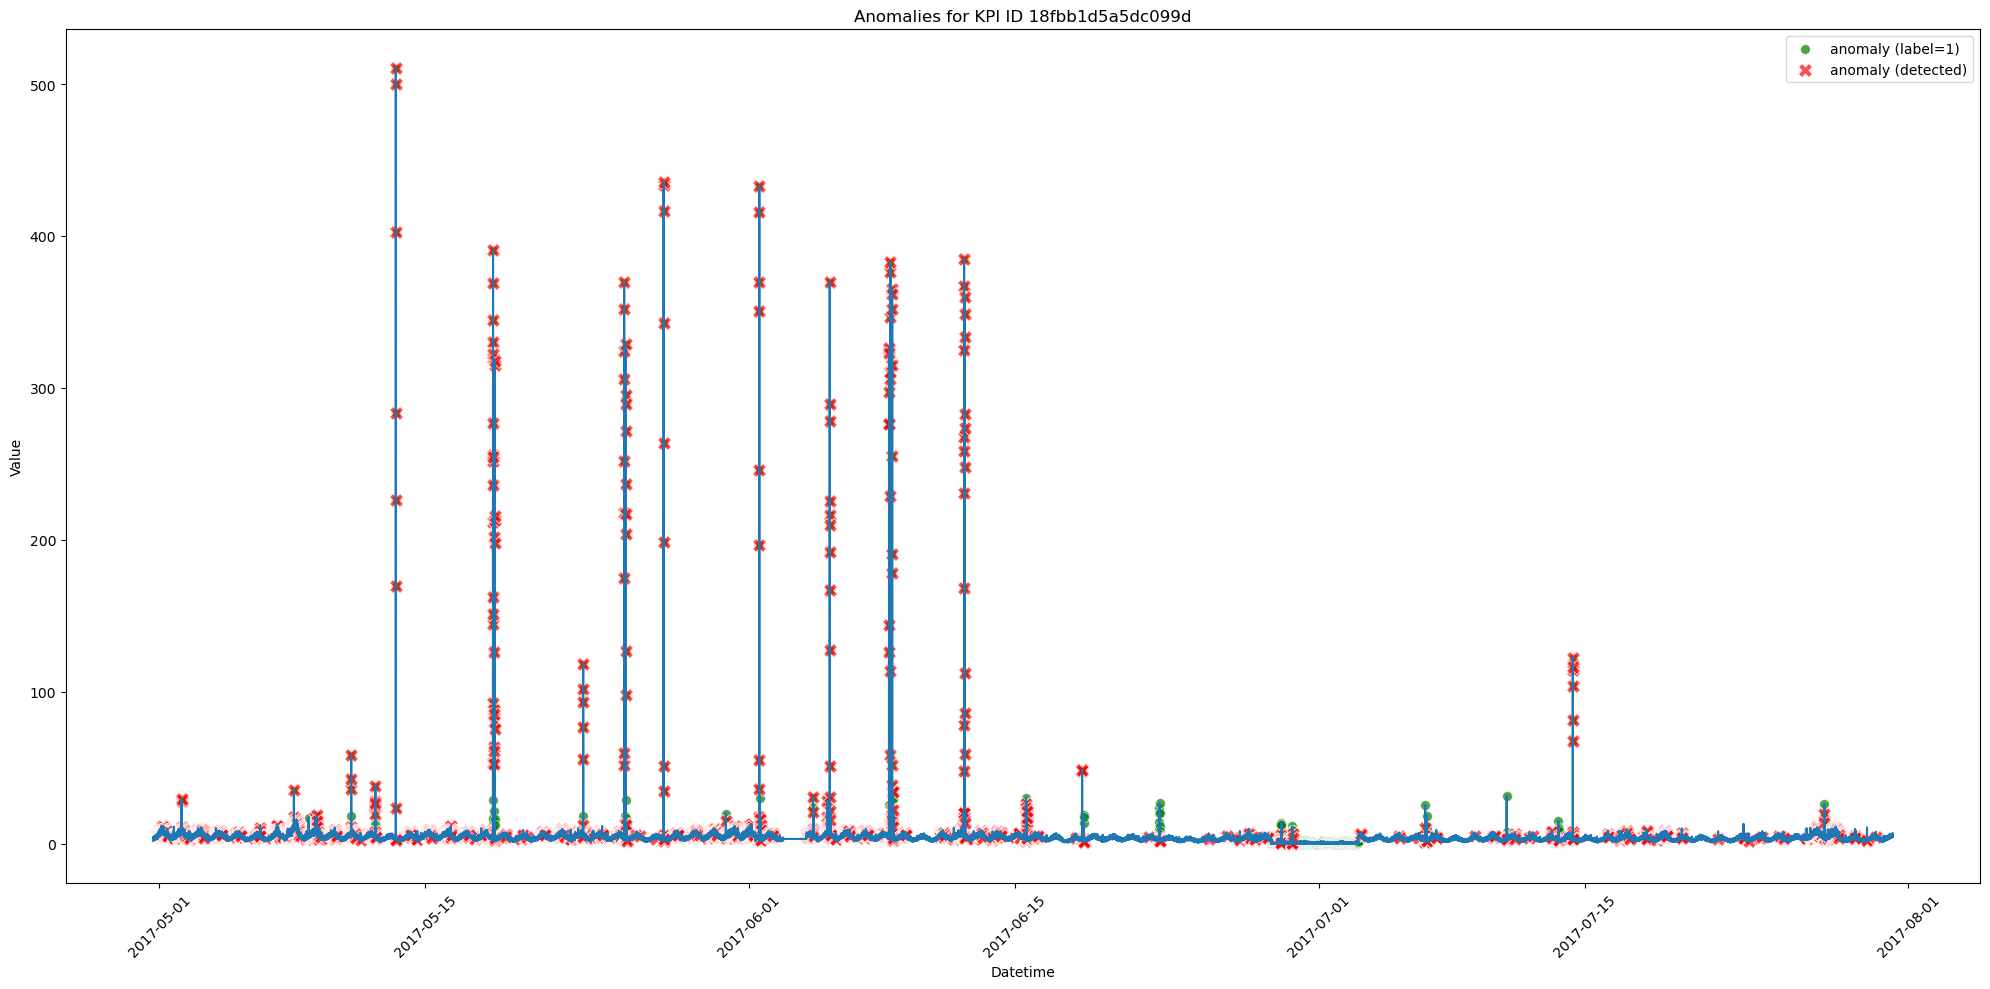

Epoch [1/5], Train Loss: 0.1618, Val Loss: 0.0055
Epoch [2/5], Train Loss: 0.0025, Val Loss: 0.0027
Epoch [3/5], Train Loss: 0.0016, Val Loss: 0.0007
Epoch [4/5], Train Loss: 0.0012, Val Loss: 0.0014
Epoch [5/5], Train Loss: 0.0009, Val Loss: 0.0011
Confusion matrix:
True Positive: 143181
False Positive: 7437
False Negative: 326
True Negative: 116
False Positive Rate: 98.46%
False Negative Rate: 0.23%
Accuracy: 94.86%
F1 Score: 2.90%
Recall: 26.24%
Precision: 1.54%


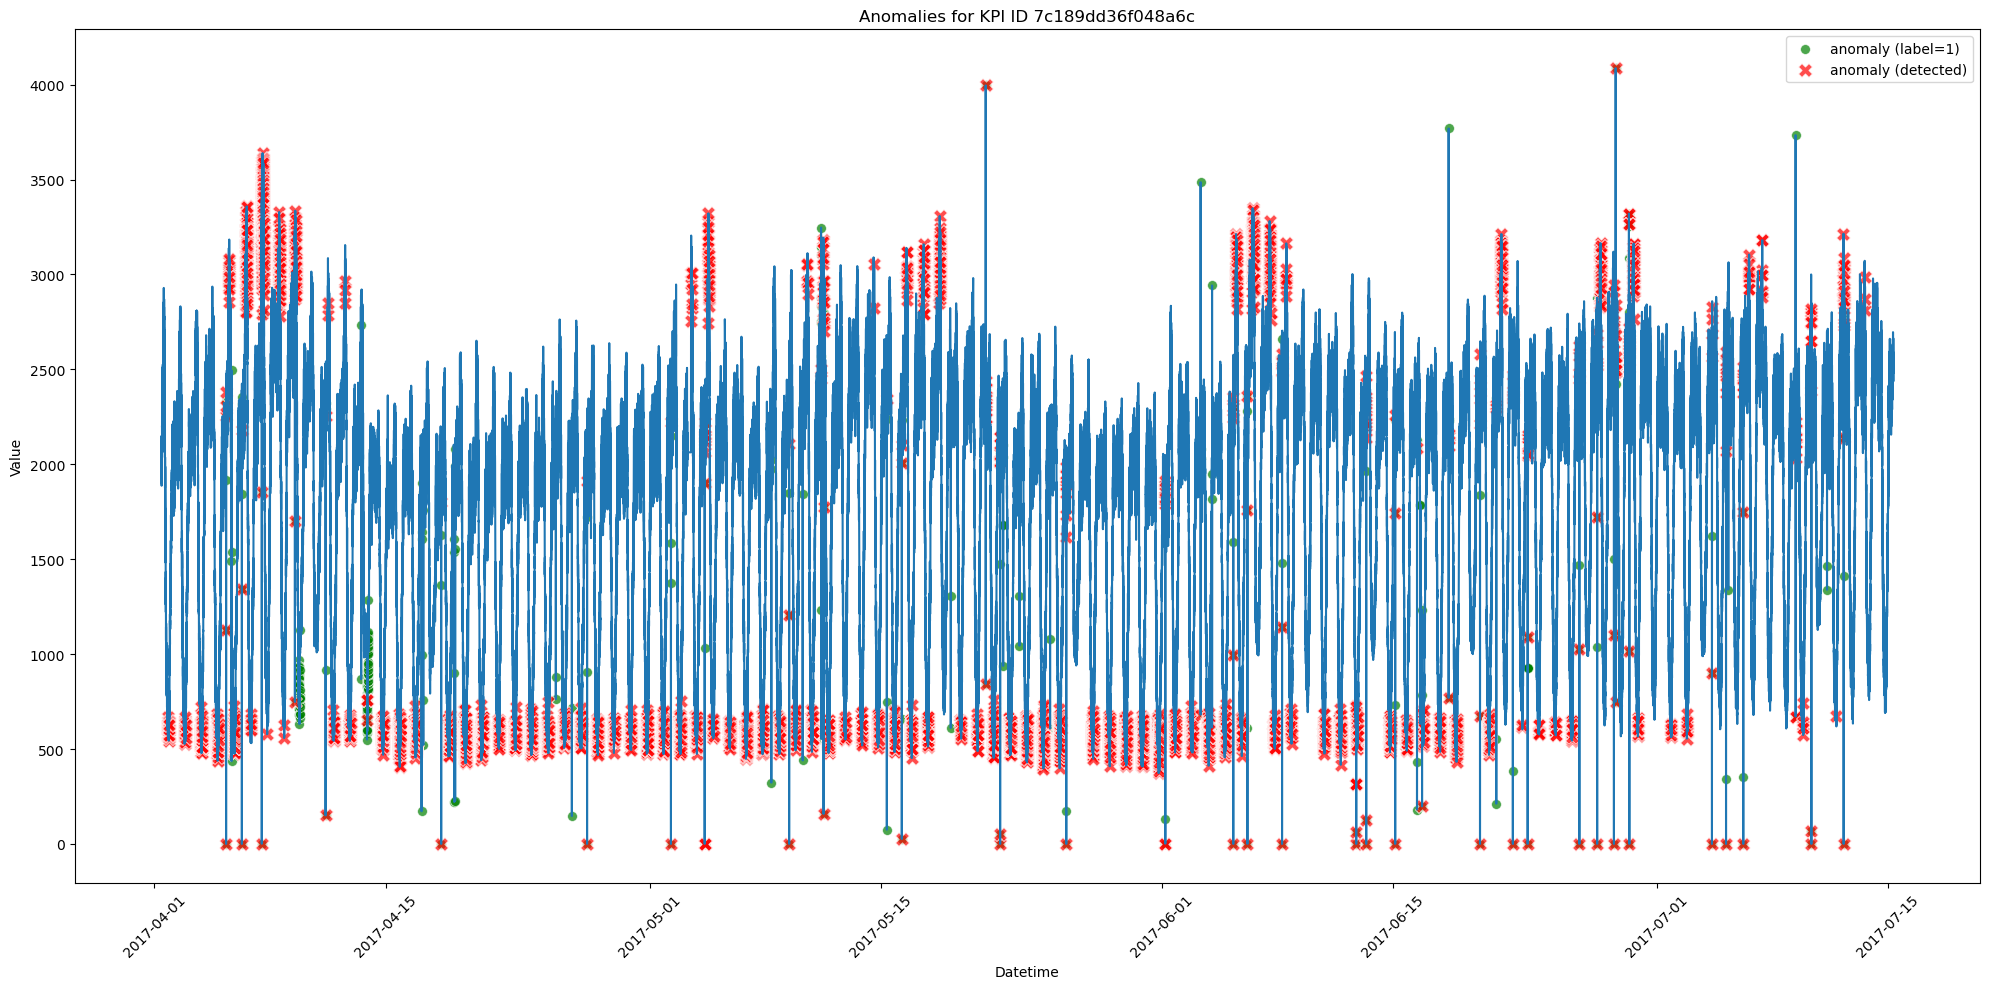

Epoch [1/5], Train Loss: 0.2116, Val Loss: 0.0019
Epoch [2/5], Train Loss: 0.0021, Val Loss: 0.0023
Epoch [3/5], Train Loss: 0.0015, Val Loss: 0.0010
Epoch [4/5], Train Loss: 0.0012, Val Loss: 0.0011
Epoch [5/5], Train Loss: 0.0010, Val Loss: 0.0008
Confusion matrix:
True Positive: 124955
False Positive: 6581
False Negative: 241
True Negative: 8
False Positive Rate: 99.88%
False Negative Rate: 0.19%
Accuracy: 94.82%
F1 Score: 0.23%
Recall: 3.21%
Precision: 0.12%


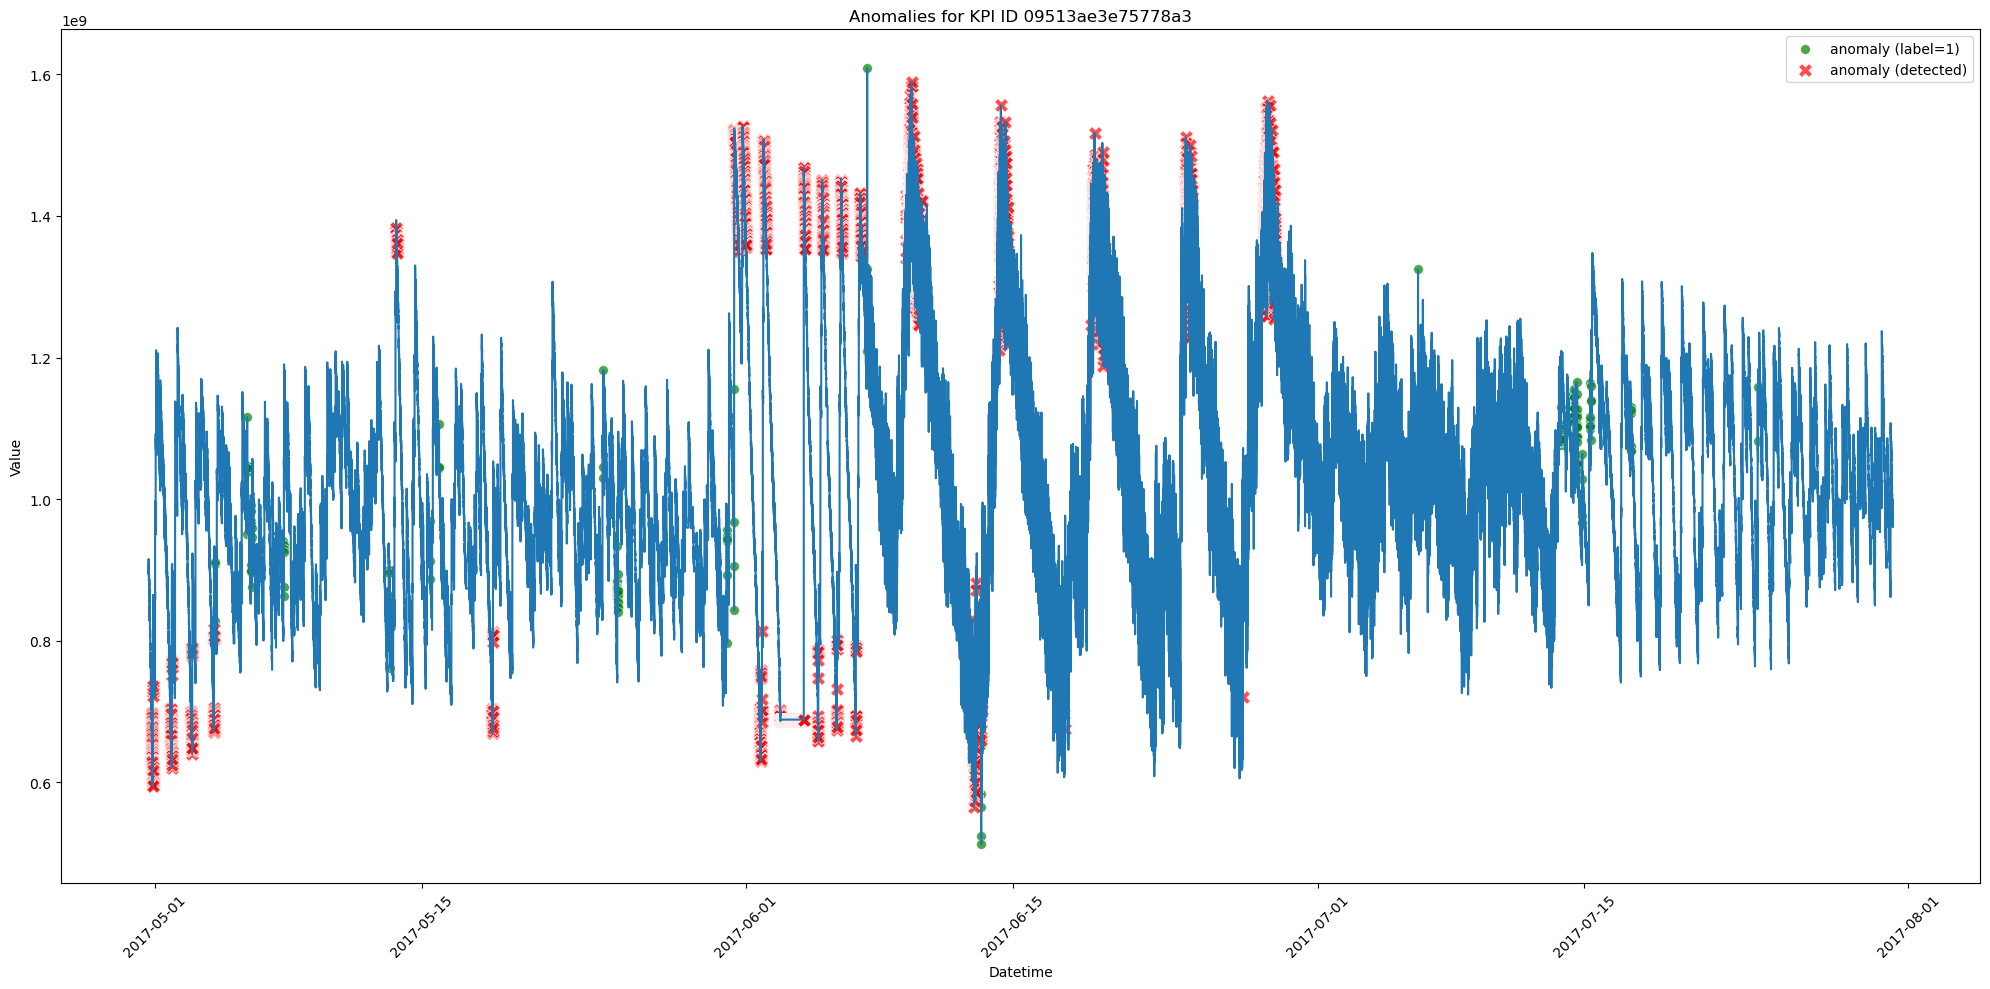

In [22]:
from utilities import (
    data_loader,
    NormalTimeSeriesDataset,
    evaluation,
    plot_anomaly_detected,
)
from model import RecurrentAutoencoder
from sklearn.model_selection import train_test_split

for KPI_ID in KPI_IDs:
    data = df_train[df_train.kpi_id == KPI_ID]
    normal_data = data[data.label == 0].drop("label", axis=1)
    abnormal_data = data[data.label == 1].drop("label", axis=1)

    train_df, val_df = train_test_split(normal_data, test_size=0.15, random_state=42)

    seq_len = 10  
    batch_size = 32  # Adjust based on your hardware capabilities

    train_loader = data_loader(train_df, seq_len=seq_len, batch_size=batch_size)
    val_loader = data_loader(val_df, seq_len=seq_len, batch_size=batch_size)

    device = "mps"
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = RecurrentAutoencoder(
        seq_len=seq_len, n_features=1, device=device, embedding_dim=64
    ).to(device)
    train_losses, val_losses = train(
        model, train_loader, val_loader, device=device, epochs=5
    )

    # Compute reconstruction errors for the entire dataset
    full_dataset = NormalTimeSeriesDataset(data, seq_len)
    reconstruction_errors = compute_errors(model, full_dataset, device)

    # Add reconstruction errors to the original data
    data["reconstruction_error"] = np.nan
    data["reconstruction_error"][seq_len - 1 :] = reconstruction_errors

    # Identify anomalies based on reconstruction error
    threshold = np.percentile(
        reconstruction_errors, 95
    )  
    data["predicted"] = (data["reconstruction_error"] > threshold).astype(int)

    # Evaluate the performance
    eval_df = evaluation(
        data["label"], data["predicted"], kpi_id=KPI_ID, method="Autoencoder"
    )

    # Plot anomalies
    anomalies = data[data["predicted"] == 1]
    eval_dict[KPI_ID] = pd.concat([eval_dict[KPI_ID], eval_df.reset_index(drop=True)])
    plot_anomaly_detected(data, anomalies)

The Autoencoder is also sentive to the anomalies, but in terms of the performance of the fist type of data, it is better than the rest. But for the low value anomaly, it can't detect them

## Model Comparison

In [32]:
merged_eval_df = pd.concat(eval_dict.values(), ignore_index=True)
merged_eval_df

kpi_id       method  Accuracy     F1  Precision  Recall     FPR  \
0  18fbb1d5a5dc099d          STL     93.83   5.57      31.87    3.05   68.13   
1  18fbb1d5a5dc099d          GMM     94.08  15.01      52.28    8.76   47.72   
2  18fbb1d5a5dc099d  Autoencoder     90.57  13.99      15.34   12.85   84.66   
3  7c189dd36f048a6c          STL     99.78  38.03      99.05   23.53    0.95   
4  7c189dd36f048a6c          GMM     98.77   4.71       3.04   10.41   96.96   
5  7c189dd36f048a6c  Autoencoder     94.86   2.90       1.54   26.24   98.46   
6  09513ae3e75778a3          STL     99.74   0.00       0.00    0.00  100.00   
7  09513ae3e75778a3          GMM     98.82   0.51       0.30    1.61   99.70   
8  09513ae3e75778a3  Autoencoder     94.82   0.23       0.12    3.21   99.88   

    FNR  
0  5.82  
1  5.50  
2  5.47  
3  0.22  
4  0.26  
5  0.23  
6  0.19  
7  0.19  
8  0.19

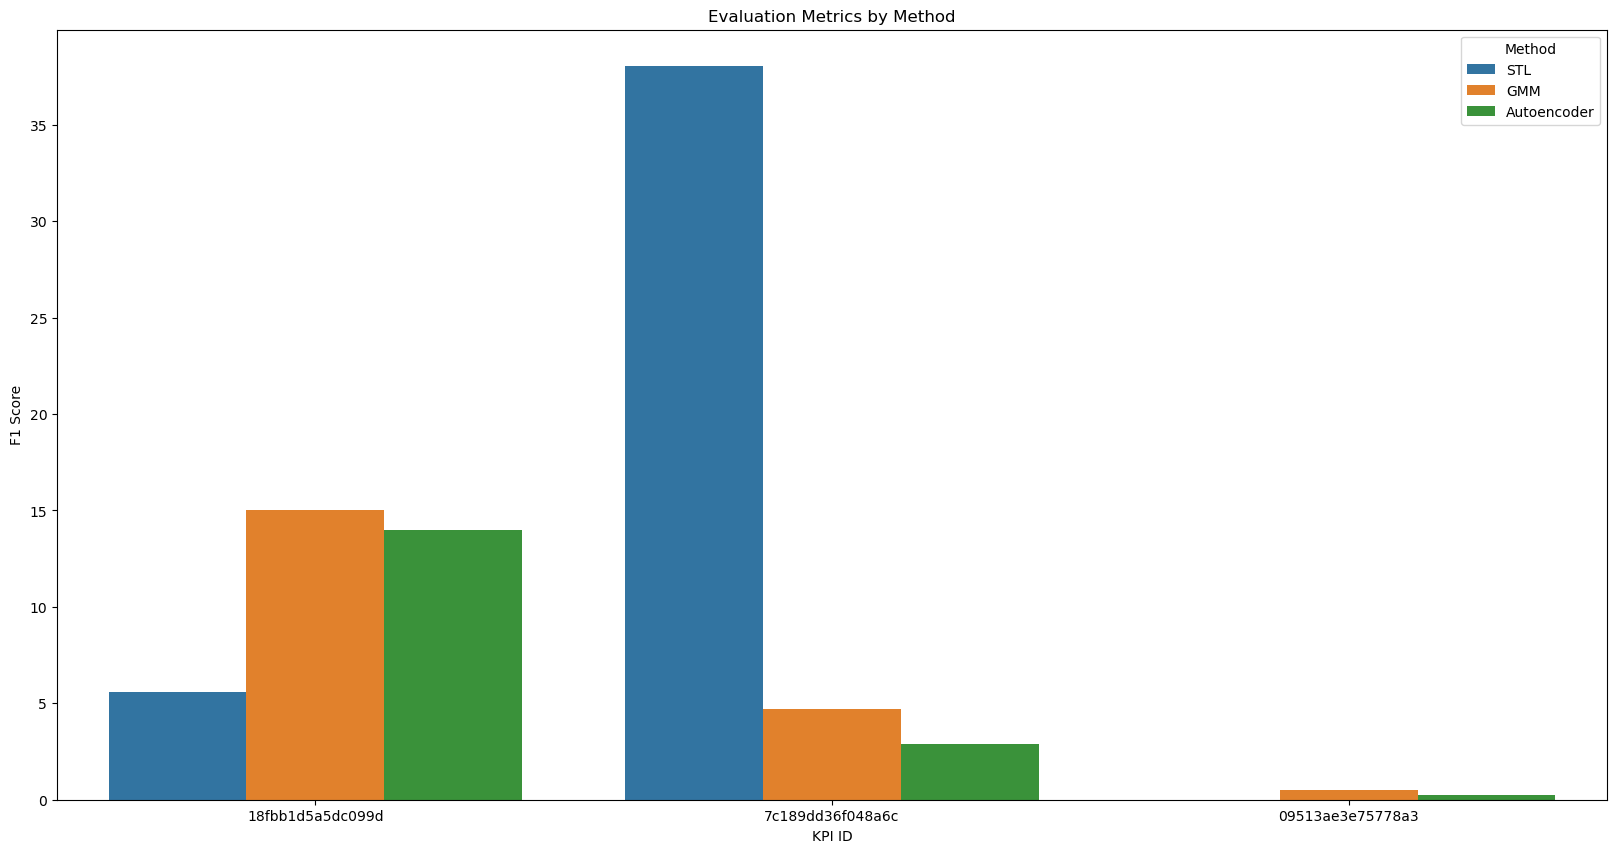

In [37]:
plt.figure(figsize=(20, 10))
sns.barplot(data=merged_eval_df, x="kpi_id", y="F1", hue="method")
plt.title("Evaluation Metrics by Method")
plt.xlabel("KPI ID")
plt.ylabel("F1 Score")
plt.legend(title="Method")
plt.show()

In general, the 3 approaches used in this notebook are too sensitive so that it has high FPR but low FNR. Howerver, the STL with rubust Z-score is the best.

According to the table that we can see for different type of datasets, model has totally different performances. For the first one which is period, GMM has the highest accuracy and the lowest FPR. Although it still has 47.72 in FPR. For the second dataset, STL almost detect all the abnomalies and without catch those normal values. It has 99.78 accuracy with only 0.95 FPR. But for the third one, all models are performs some problems in FPR, they catch the abnomalies but also include a lot of normal values into it. We think that it is because of the complexity of the third dataset is much higher than the others. 

# Reference

1. [Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python
](https://colab.research.google.com/github/curiousily/Getting-Things-Done-with-Pytorch/blob/master/06.time-series-anomaly-detection-ecg.ipynb#scrollTo=n7kJ7C3IFWIV)
2. T. Veracini, S. Matteoli, M. Diani and G. Corsini, "Fully Unsupervised Learning of Gaussian Mixtures for Anomaly Detection in Hyperspectral Imagery," 2009 Ninth International Conference on Intelligent Systems Design and Applications, Pisa, Italy, 2009, pp. 596-601, doi: 10.1109/ISDA.2009.220.